### Gumbel-Quantized VAE

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("Torch version:[%s]"%(torch.__version__))

Torch version:[1.12.0.dev20220519]


### MNIST

In [2]:
def np2torch(x_np,device='cpu'):
    """ Numpy tensor to Torch tensor """
    return torch.tensor(x_np,dtype=torch.float32,device=device)
def torch2np(x_torch):
    """ Torch tensor to Numpy tensor """
    return x_torch.detach().cpu().numpy()

In [3]:
from torchvision import datasets,transforms
mnist_train = datasets.MNIST(
    root='../data/',train=True,transform=transforms.ToTensor(),download=True)
mnist_test  = datasets.MNIST(
    root='../data/',train=False,transform=transforms.ToTensor(),download=True)
# Training data
x_train_torch = mnist_train.data.float().reshape(-1,784)/255.
y_train_torch = mnist_train.targets
x_test_torch  = mnist_test.data.float().reshape(-1,784)/255.
y_test_torch  = mnist_test.targets
x_train_np,x_test_np = torch2np(x_train_torch),torch2np(x_test_torch)
y_train_np,y_test_np = torch2np(y_train_torch),torch2np(y_test_torch)
n_train,n_test = x_train_np.shape[0],x_test_np.shape[0]
print ("x_train_np:%s x_test_np:%s"%(x_train_np.shape,x_test_np.shape,))
print ("n_train:[%d] n_test:[%d]"%(n_train,n_test))

x_train_np:(60000, 784) x_test_np:(10000, 784)
n_train:[60000] n_test:[10000]


/opt/homebrew/Caskroom/miniforge/base/envs/torch-mac/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


### Util

In [4]:
class GumbelQuantizerClass(nn.Module):
    """
        Gumbel Quantizer Class
    """
    def __init__(self,
                 name  = 'GQ',
                 K     = 10,
                 z_dim = 5,
                 e_dim = 2,
                 e_min = -1.0,
                 e_max = 1.0,
                 beta  = 1.0,
                 codebook_weight_np = None,
                 FREEZE_CODEBOOK    = True):
        """
            Initialize GQ
        """
        super(GumbelQuantizerClass,self).__init__()
        self.name  = name
        self.K     = K     # number of codebook
        self.z_dim = z_dim # input (latent vector) dimension
        self.e_dim = e_dim # codebook dimension
        self.e_min = e_min
        self.e_max = e_max
        self.beta  = beta  # loss weight
        self.FREEZE_CODEBOOK = FREEZE_CODEBOOK
        # Initialize projection layer
        self.init_projection()    
        # Initialize codebook
        self.init_codebook()
        if codebook_weight_np is not None:
            self.codebook.weight.data = np2torch(codebook_weight_np)
    
    def init_projection(self):
        """
            Initialize projection layer
        """
        self.projection = nn.Linear(self.z_dim,self.K)
        nn.init.normal_(self.projection.weight,mean=0.0,std=0.1)
        nn.init.zeros_(self.projection.bias)
        
    def init_codebook(self):
        """
            Initialize codebook
        """
        self.codebook = nn.Embedding(self.K,embedding_dim=self.e_dim) # [K x e_dim]
        self.codebook.weight.data.uniform_(self.e_min,self.e_max)
        
    def get_codebook(self):
        return self.codebook.weight
        
    def forward(self,
                z,
                tau        = 1.0,   # temperature
                USE_GUMBEL = True,  # use gumbel_softmax or softmax
                ONEHOT     = False, # use onehot vector or not
                ARGMAX     = False  # use argmax (for evaluation purpose)
               ):
        """
            Forward
            z          : latent vector [B x z_dim]
            tau        : temperature
            USE_GUMBEL : use 'Gumbel Softmax' (True) or 'Softmax' (False)
            ONEHOT     : one hot vector
            ARGMAX     : use 'ArgMax'
            - Note that when using 'Softmax' or 'ArgMax', learning is not possible
        """
        logits = self.projection(z) # [B x K]
        codebook_weight = self.codebook.weight
        if ARGMAX:
            codebook_probs = F.one_hot(torch.argmax(logits,dim=1),num_classes=self.K) # [B x K]
            codebook_probs = codebook_probs.type(torch.float)
        else:
            if USE_GUMBEL: # use gumbel softmax (reparametrization or straight-through)
                codebook_probs = F.gumbel_softmax(logits=logits/tau,tau=tau,dim=1,hard=ONEHOT) # [B x K]
            else:
                codebook_probs = F.softmax(logits/tau,dim=1) # [B x K]
                if ONEHOT: # sample from categorical
                    C = torch.distributions.Categorical(probs=codebook_probs)
                    codebook_probs = F.one_hot(C.sample(),num_classes=self.K) # [B x K]
                    codebook_probs = codebook_probs.type(torch.float)
        if self.FREEZE_CODEBOOK:
            e = torch.matmul(codebook_probs,codebook_weight.detach()) # [B x E]
        else: 
            e = torch.matmul(codebook_probs,codebook_weight) # [B x E]
        # Loss
        codebook_probs; # [B x K]
        avg_codebook_probs = torch.mean(codebook_probs,dim=0) # [K]
        utilization_loss = self.beta * torch.sum(
            avg_codebook_probs * torch.log(avg_codebook_probs + 1e-6)) # [1]
        out  = {'codebook_weight':self.codebook.weight,'logits':logits,'e':e,
                'codebook_probs':codebook_probs,'avg_codebook_probs':avg_codebook_probs,
                'utilization_loss':utilization_loss}
        return out
print ("Ready.")

Ready.


### Gumbel Quantized VAE

In [5]:
class GQVAE_Class(nn.Module):
    """
        Gumbel Quantized Variational Autoencoder
    """
    def __init__(self,
                 name     = 'GQVAE',
                 x_dim    = 784,       # input dimension
                 z_dim    = 16,        # latent dimension
                 e_dim    = 10,        # codebook dimension
                 K        = 10,        # number of codes
                 h_dims   = [128,32],  # hidden dimensions of encoder and decoder 
                 e_range  = [0,1],     # code value range (None or [e_min,e_max])
                 beta     = 1e-3,      # weight for 'utilization_loss'
                 enc_actv = nn.ReLU(), # encoder activation
                 dec_actv = nn.ReLU(), # decoder activation
                 out_actv = None,      # output activation
                 device   = 'cpu',
                 FREEZE_CODEBOOK         = True,
                 USE_ORTHOGONAL_CODEBOOK = False
                ):
        """
            Initialize GQVAE
        """
        super(GQVAE_Class,self).__init__()
        self.name     = name
        self.x_dim    = x_dim
        self.z_dim    = z_dim
        self.e_dim    = e_dim
        self.K        = K
        self.h_dims   = h_dims
        self.e_range  = e_range
        self.beta     = beta
        self.enc_actv = enc_actv
        self.dec_actv = dec_actv
        self.out_actv = out_actv
        self.device   = device
        self.USE_ORTHOGONAL_CODEBOOK = USE_ORTHOGONAL_CODEBOOK
        # Initialize layers
        self.init_layers()
        # Initialize parameters
        self.init_params()
        # Instantiate Gumber quantizer
        if self.USE_ORTHOGONAL_CODEBOOK:
            assert (self.K==self.e_dim),'self.K(=%d) should equal to self.e_dim(=%d)'%(self.K,self.e_dim)
            codebook_weight_np = np.eye(self.K,self.e_dim)
        else:
            codebook_weight_np = None
        self.GQ = GumbelQuantizerClass(
            name  = '%s_GQ'%(self.name),
            K     = self.K,
            z_dim = self.z_dim,
            e_dim = self.e_dim,
            e_min = self.e_range[0],
            e_max = self.e_range[1],
            beta  = self.beta,
            codebook_weight_np = codebook_weight_np,
            FREEZE_CODEBOOK    = FREEZE_CODEBOOK
        )

    def init_layers(self):
        """
            Initialize layers
        """
        self.layers = {}
        # Encoder part (x to z)
        h_dim_prev = self.x_dim
        for h_idx,h_dim in enumerate(self.h_dims):
            self.layers['enc_%02d_lin'%(h_idx)]  = nn.Linear(h_dim_prev,h_dim,bias=True)
            self.layers['enc_%02d_actv'%(h_idx)] = self.enc_actv
            h_dim_prev = h_dim
        self.layers['z_lin']  = nn.Linear(h_dim_prev,self.z_dim,bias=True) # [z_dim]
        # Decoder part (e to x)
        h_dim_prev = self.e_dim
        for h_idx,h_dim in enumerate(self.h_dims[::-1]):
            self.layers['dec_%02d_lin'%(h_idx)]  = nn.Linear(h_dim_prev,h_dim,bias=True)
            self.layers['dec_%02d_actv'%(h_idx)] = self.dec_actv
            h_dim_prev = h_dim
        self.layers['out_lin'] = nn.Linear(h_dim_prev,self.x_dim,bias=True) # [x_dim]
        # Append parameters
        self.param_dict = {}
        for key in self.layers.keys():
            layer = self.layers[key]
            if isinstance(layer,nn.Linear):
                self.param_dict[key+'_w'] = layer.weight
                self.param_dict[key+'_b'] = layer.bias
        self.parameters = nn.ParameterDict(self.param_dict)
        self.to(self.device)
        
    def init_params(self):
        """
            Initialize parameters
        """
        for key in self.layers.keys():
            layer = self.layers[key]
            if isinstance(layer,nn.Linear):
                nn.init.normal_(layer.weight,mean=0.0,std=0.1)
                nn.init.zeros_(layer.bias)
            elif isinstance(layer,nn.BatchNorm2d):
                nn.init.constant_(layer.weight,1.0)
                nn.init.constant_(layer.bias,0.0)
            elif isinstance(layer,nn.Conv2d):
                nn.init.kaiming_normal_(layer.weight)
                nn.init.zeros_(layer.bias)
                
        if self.USE_ORTHOGONAL_CODEBOOK:
            assert (self.K==self.e_dim),'self.K(=%d) should equal to self.e_dim(=%d)'%(self.K,self.e_dim)
            codebook_weight_np = np.eye(self.K,self.e_dim)
                
    def get_codebook(self):
        """
            Get codebook
        """
        codebook = self.GQ.get_codebook() # [K x e_dim]
        return codebook
    
    def x_to_z(self,x):
        """
            Input 'x' to latent vector 'z'
        """
        net = x
        for h_idx,_ in enumerate(self.h_dims):
            net = self.layers['enc_%02d_lin'%(h_idx)](net)
            net = self.layers['enc_%02d_actv'%(h_idx)](net)
        z = self.layers['z_lin'](net)
        return z
                
    def z_to_gq_out(self,
               z,
               tau        = 1.0,   # temperature
               USE_GUMBEL = True,  # use gumbel_softmax or softmax
               ONEHOT     = False, # use onehot vector or not
               ARGMAX     = False  # use argmax (for evaluation purpose)
              ):
        """
            latent vector z to gumbel-quantizer output
        """
        gq_out = self.GQ(
            z          = z.to(self.device),
            tau        = 1.0,
            USE_GUMBEL = USE_GUMBEL,
            ONEHOT     = ONEHOT,
            ARGMAX     = ARGMAX)
        return gq_out
    
    def z_to_e(self,
               z,
               tau        = 1.0,   # temperature
               USE_GUMBEL = True,  # use gumbel_softmax or softmax
               ONEHOT     = False, # use onehot vector or not
               ARGMAX     = False  # use argmax (for evaluation purpose)
              ):
        """
            latent vector z to codebook e with gumbel-quantizer
        """
        out = self.GQ(
            z          = z.to(self.device),
            tau        = 1.0,
            USE_GUMBEL = USE_GUMBEL,
            ONEHOT     = ONEHOT,
            ARGMAX     = ARGMAX)
        e = out['e']
        return e
    
    def e_to_x_recon(self,e):
        """
            Code 'e' to reconstructed input 'x_recon'
        """
        net = e
        for h_idx,_ in enumerate(self.h_dims[::-1]):
            net = self.layers['dec_%02d_lin'%(h_idx)](net)
            net = self.layers['dec_%02d_actv'%(h_idx)](net)
        net = self.layers['out_lin'](net)
        if self.out_actv is not None:
            net = self.out_actv(net)
        x_recon = net
        return x_recon
    
    def x_to_x_recon(self,
                     x,
                     tau        = 1.0,   # temperature
                     USE_GUMBEL = True,  # use gumbel_softmax or softmax
                     ONEHOT     = False, # use onehot vector or not
                     ARGMAX     = False  # use argmax (for evaluation purpose)
                    ):
        """
            Input 'x' to reconstructed input 'x_recon'
        """
        z = self.x_to_z(x=x)
        e = self.z_to_e(z=z,tau=tau,USE_GUMBEL=USE_GUMBEL,ONEHOT=ONEHOT,ARGMAX=ARGMAX)
        x_recon = self.e_to_x_recon(e=e)
        return x_recon
    
    def code_idx_to_x_recon(self,code_idx=0):
        """
            Code index to 'x_recon'
        """
        codebook = self.get_codebook() # [K x e_dim]
        e = codebook[code_idx,:] # [e_dim]
        x_recon = self.e_to_x_recon(e=e)
        return x_recon
    
    def loss(self,
             x,
             tau          = 1.0,   # temperature
             USE_GUMBEL   = True,  # use gumbel_softmax or softmax
             ONEHOT       = False, # use onehot vector or not
             ARGMAX       = False, # use argmax (for evaluation purpose)
             l1_weight    = 1.0,   # L1 reconstruction weight
             l2_weight    = 1.0,   # L2 reconstruction weight
             util_weight  = 1.0    # utilization loss weight
            ):
        """
            Compute loss
        """
        # Reconstruction loss
        x_recon    = self.x_to_x_recon(x=x) # [B x x_dim]
        l1_errs    = l1_weight*torch.mean(torch.abs(x-x_recon),axis=1) # [B]
        l2_errs    = l2_weight*torch.mean(torch.square(x-x_recon),axis=1) # [B]
        l1_loss    = l1_errs.mean()  # [1]
        l2_loss    = l2_errs.mean()  # [1]
        recon_loss = l1_loss + l2_loss # [1]
        # Codebook utilization loss
        z          = self.x_to_z(x=x)
        gq_out     = self.z_to_gq_out(
            z=z,tau=tau,USE_GUMBEL=USE_GUMBEL,ONEHOT=ONEHOT,ARGMAX=ARGMAX)
        util_loss  = util_weight*gq_out['utilization_loss'] # [1]
        # Total loss
        total_loss = recon_loss + util_loss # [1wa]
        loss_out = {'x_recon':x_recon,'l1_errs':l1_errs,'l2_errs':l2_errs,
                    'recon_loss':recon_loss,'l1_loss':l1_loss,'l2_loss':l2_loss,
                    'gq_out':gq_out,'util_loss':util_loss,'total_loss':total_loss}
        return loss_out
    

print ("Ready.")

Ready.


### Instantiate GQ-VAE object

In [6]:
GQVAE = GQVAE_Class(
    name = 'GQVAE_MNIST',
    x_dim    = 784,       # input dimension
    z_dim    = 32,        # latent dimension
    e_dim    = 20,        # codebook dimension
    K        = 20,        # number of codes
    h_dims   = [256,256], # hidden dimensions of encoder and decoder 
    e_range  = [0,1],     # code value range (None or [e_min,e_max])
    beta     = 1.0,       # weight for 'utilization_loss'
    enc_actv = nn.ReLU(), # encoder activation
    dec_actv = nn.ReLU(), # decoder activation
    out_actv = None,      # output activation
    device   = 'cpu',
    FREEZE_CODEBOOK         = True,
    USE_ORTHOGONAL_CODEBOOK = True
    )
print ('[%s] instantiated.'%(GQVAE.name))

[GQVAE_MNIST] instantiated.


In [7]:
# Hyperparameters
n_epoch,print_every,batch_size,plot_every = 100,1,128,10
n_it = (n_train//batch_size)+1 # number of iterations
tau_max,tau_min = 1.0,0.01 # temperature scheduling
optm = torch.optim.Adam(
    params       = GQVAE.parameters(),
    lr           = 1e-4,
    betas        = (0.9,0.099),  # (0.9, 0.999)
    eps          = 1e-6, # 1e-8
    weight_decay = 0.0,
)
print ("Ready.")

Ready.


### Train

In [8]:
def gqvae_mnist_debug(GQVAE_TEST,tau=1.0):
    # To eval mode
    GQVAE_TEST.eval()
    # Configuration
    figsize_recon,n_test_img    = (12,1.5),10
    figsize_sample,n_sample_img = (12,2.5),20
    figsize_latent              = (12,3)
    n_test = x_test_np.shape[0]
    
    # Plot test images
    rand_test_idxs = np.random.permutation(n_test)[:n_test_img]
    fig = plt.figure(figsize=figsize_recon)
    for i_idx in range(n_test_img):
        plt.subplot(1,n_test_img,i_idx+1)
        plt.imshow(x_test_np[rand_test_idxs[i_idx],:].reshape((28,28)),
                   vmin=0,vmax=1,cmap='gray'); plt.axis('off')
    fig.suptitle("Test images",fontsize=15);plt.show()
    
    # Plot reconstructed images (argmax for evaluation)
    x_test_torch = np2torch(x_test_np)
    x_recon_np = torch2np(GQVAE_TEST.x_to_x_recon(x=x_test_torch[rand_test_idxs,:],ARGMAX=True))
    fig = plt.figure(figsize=figsize_recon)
    for i_idx in range(n_test_img):
        plt.subplot(1,n_test_img,i_idx+1)
        plt.imshow(x_recon_np[i_idx,:].reshape((28,28)),
                   vmin=0,vmax=1,cmap='gray'); plt.axis('off')
    fig.suptitle("Reconstructed images (ArgMax)",fontsize=15);plt.show()
    
    # Plot reconstructed images (gumbel soft)
    x_test_torch = np2torch(x_test_np)
    x_recon_np   = torch2np(GQVAE_TEST.x_to_x_recon(
        x          = x_test_torch[rand_test_idxs,:],
        tau        = tau,   # temperature
        USE_GUMBEL = True,  # use gumbel_softmax or softmax
        ONEHOT     = True,  # use onehot vector or not
        ARGMAX     = False  # use argmax (for evaluation purpose)
        ))
    fig = plt.figure(figsize=figsize_recon)
    for i_idx in range(n_test_img):
        plt.subplot(1,n_test_img,i_idx+1)
        plt.imshow(x_recon_np[i_idx,:].reshape((28,28)),
                   vmin=0,vmax=1,cmap='gray'); plt.axis('off')
    fig.suptitle("Reconstructed images (Gaumbel Soft tau:%.2f)"%(tau),fontsize=15);plt.show()
    
    # Plot reconstructed images (gumbel soft)
    x_test_torch = np2torch(x_test_np)
    x_recon_np   = torch2np(GQVAE_TEST.x_to_x_recon(
        x          = x_test_torch[rand_test_idxs,:],
        tau        = tau,   # temperature
        USE_GUMBEL = True,  # use gumbel_softmax or softmax
        ONEHOT     = False, # use onehot vector or not
        ARGMAX     = False  # use argmax (for evaluation purpose)
        ))
    fig = plt.figure(figsize=figsize_recon)
    for i_idx in range(n_test_img):
        plt.subplot(1,n_test_img,i_idx+1)
        plt.imshow(x_recon_np[i_idx,:].reshape((28,28)),
                   vmin=0,vmax=1,cmap='gray'); plt.axis('off')
    fig.suptitle("Reconstructed images (Gaumbel Hard tau:%.2f)"%(tau),fontsize=15);plt.show()
    
    # Plot sampled images
    fig = plt.figure(figsize=figsize_sample)
    for i_idx in range(n_sample_img):
        plt.subplot(2,n_sample_img//2,i_idx+1)
        x_sample_torch = GQVAE_TEST.code_idx_to_x_recon(code_idx=i_idx)
        x_sample_np = torch2np(x_sample_torch)
        plt.imshow(x_sample_np.reshape((28,28)),
                   vmin=0,vmax=1,cmap='gray'); plt.axis('off')
    fig.suptitle("Codebook images",fontsize=15);plt.show()
    # Plot codebook
    plt.figure(figsize=(5,5))
    im = plt.matshow(torch2np(GQVAE.get_codebook()),fignum=1)
    plt.colorbar(im,fraction=0.046, pad=0.04)
    plt.title('Codebook',fontsize=15)
    plt.show()
    # To train mode
    GQVAE_TEST.train()
print ("Ready")

Ready


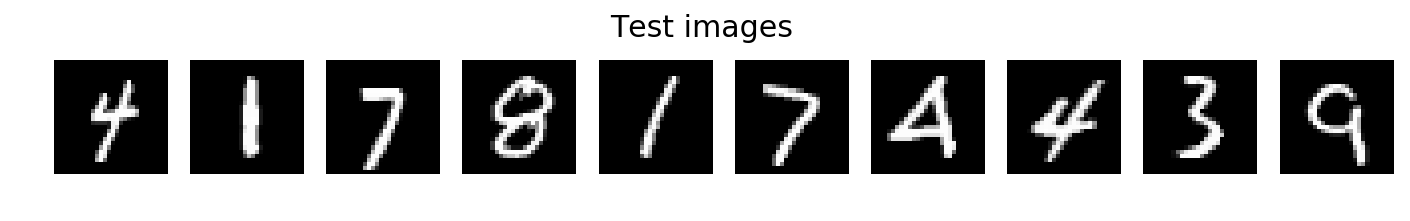

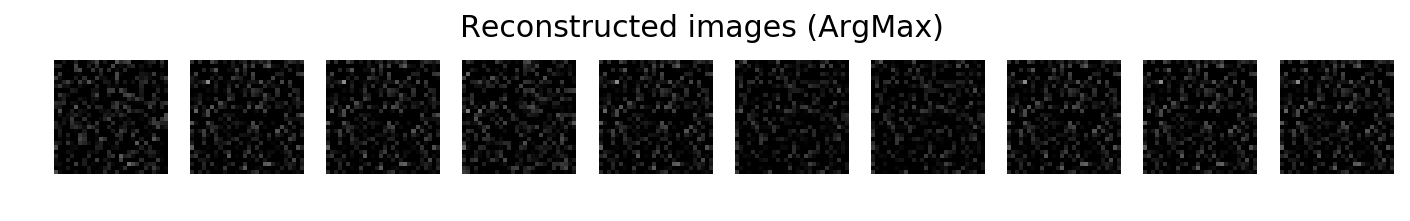

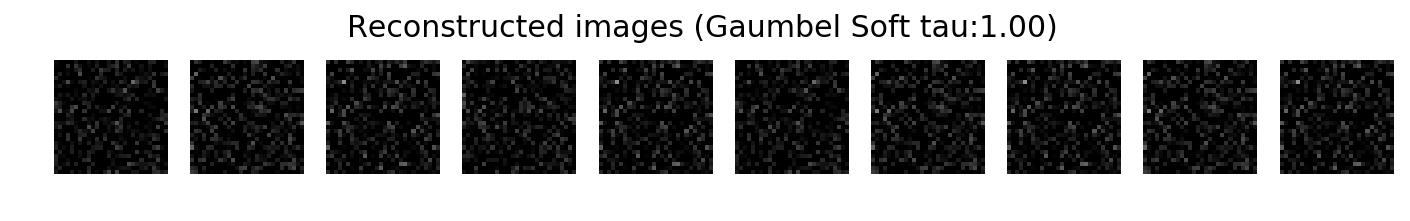

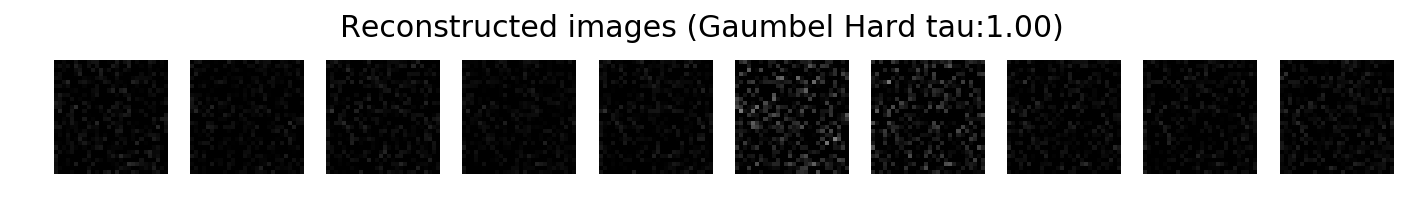

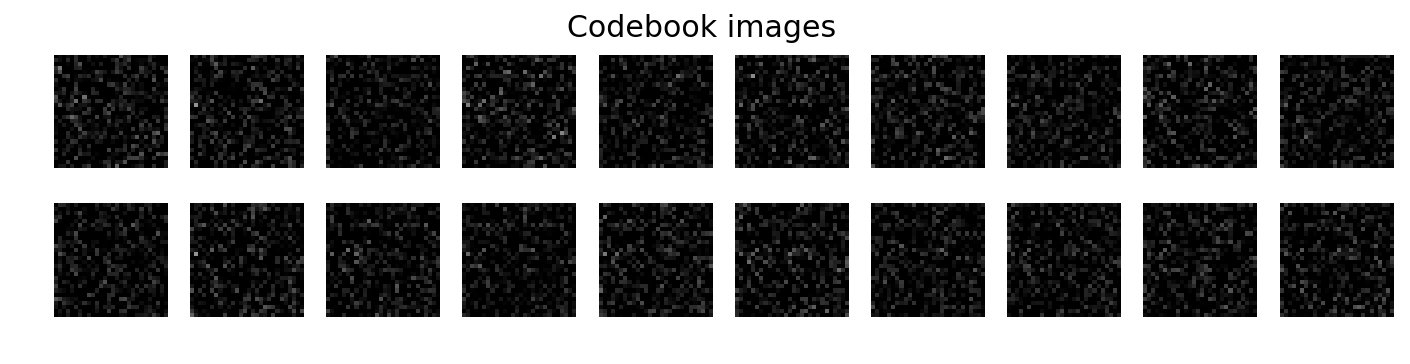

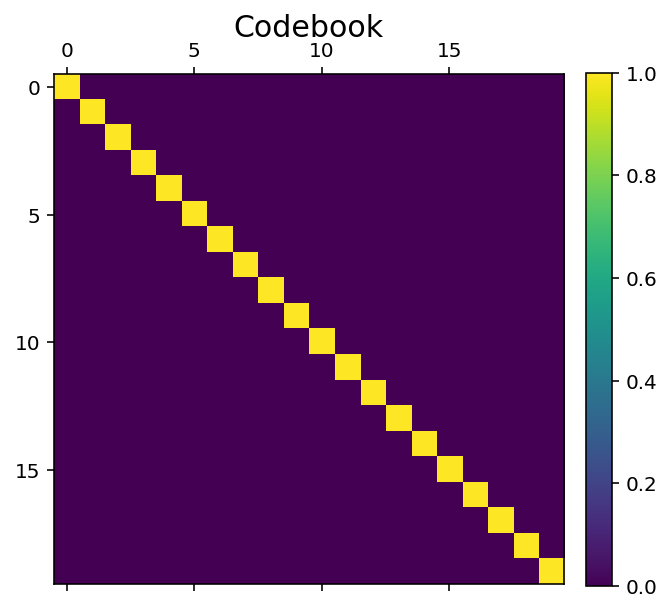

In [9]:
GQVAE.init_params()
gqvae_mnist_debug(GQVAE_TEST=GQVAE)

Start training.
[0/100] total:[0.232] l1:[0.136] l2:[0.098] utilization:[-0.002] tau:[1.000]


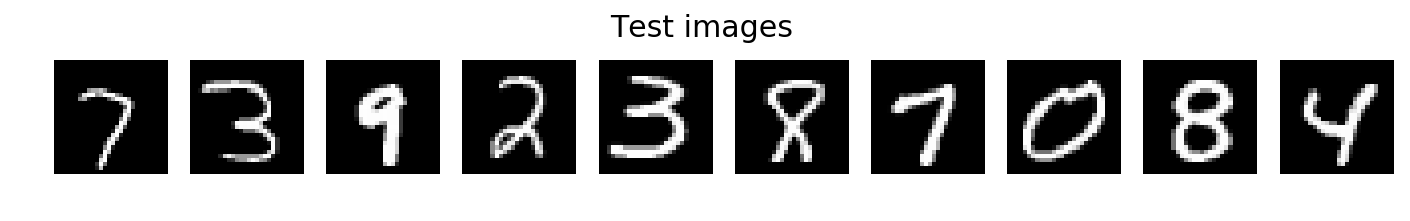

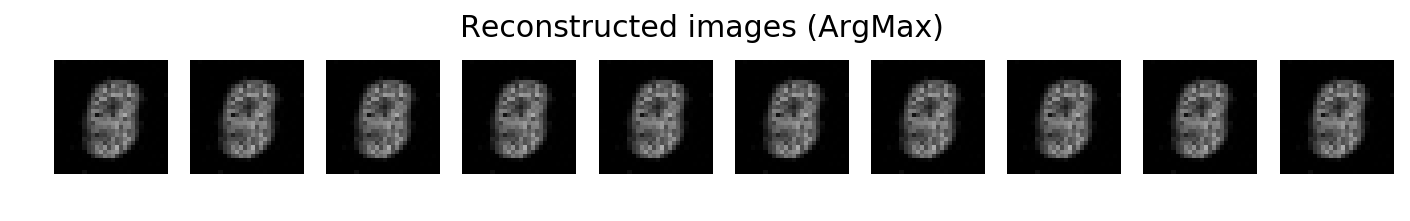

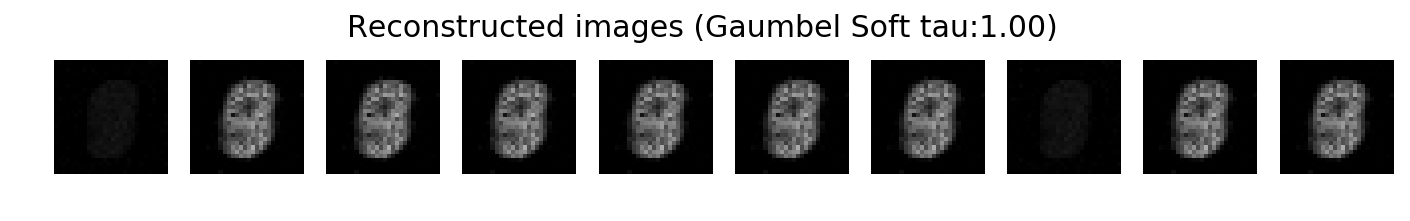

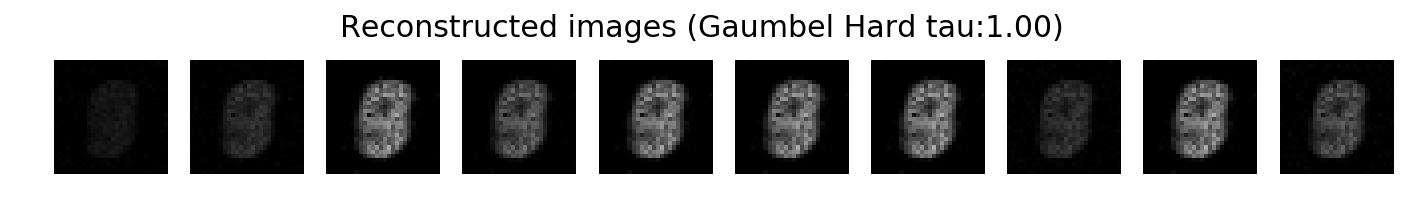

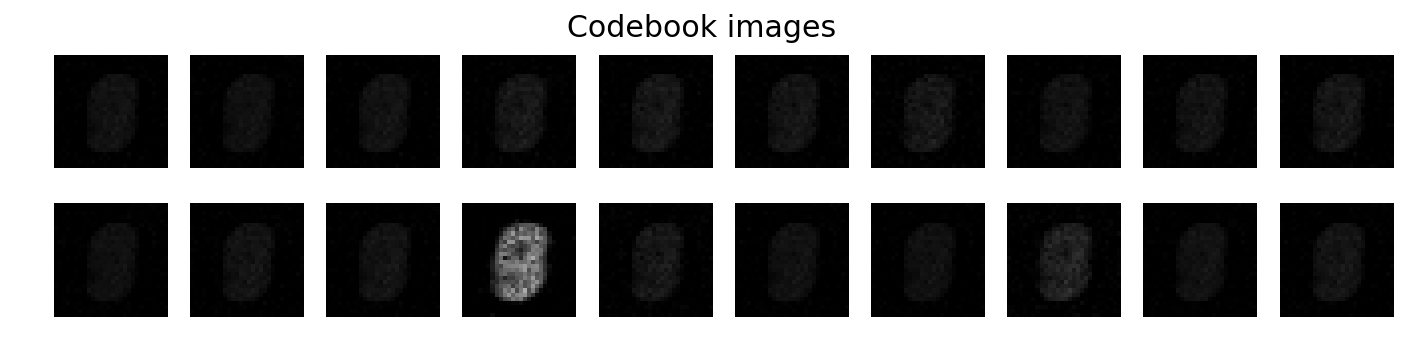

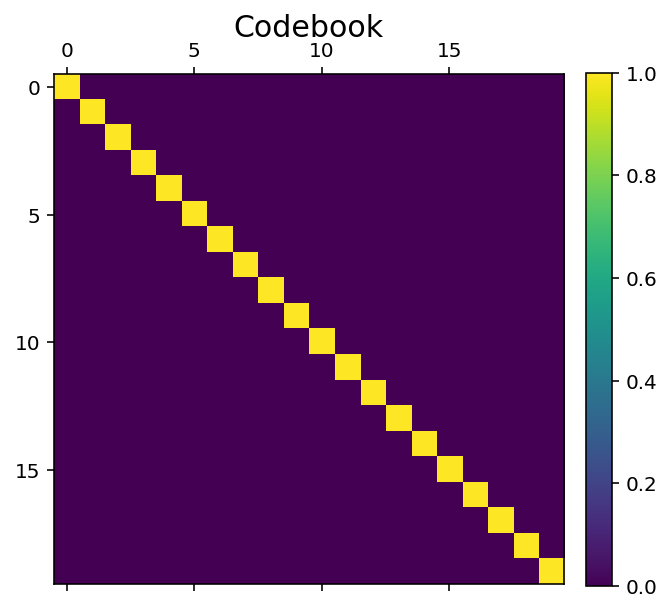

[1/100] total:[0.195] l1:[0.125] l2:[0.071] utilization:[-0.002] tau:[0.990]
[2/100] total:[0.190] l1:[0.123] l2:[0.069] utilization:[-0.002] tau:[0.980]
[3/100] total:[0.188] l1:[0.122] l2:[0.068] utilization:[-0.003] tau:[0.970]
[4/100] total:[0.186] l1:[0.122] l2:[0.067] utilization:[-0.003] tau:[0.960]
[5/100] total:[0.185] l1:[0.121] l2:[0.067] utilization:[-0.003] tau:[0.950]
[6/100] total:[0.184] l1:[0.121] l2:[0.066] utilization:[-0.003] tau:[0.940]
[7/100] total:[0.183] l1:[0.121] l2:[0.065] utilization:[-0.003] tau:[0.930]
[8/100] total:[0.178] l1:[0.118] l2:[0.063] utilization:[-0.003] tau:[0.920]
[9/100] total:[0.176] l1:[0.116] l2:[0.063] utilization:[-0.003] tau:[0.910]
[10/100] total:[0.175] l1:[0.115] l2:[0.062] utilization:[-0.003] tau:[0.900]


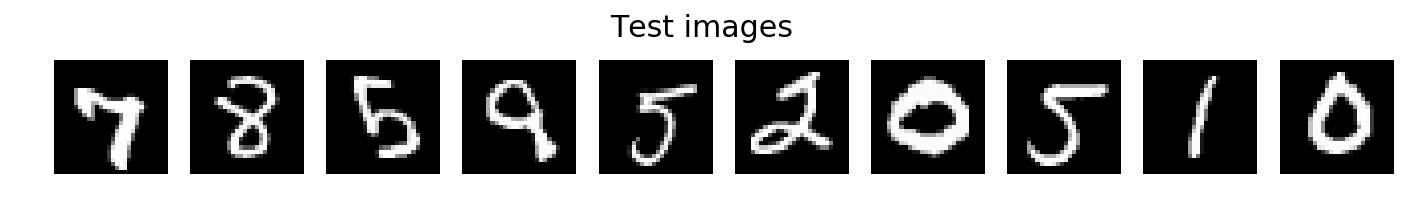

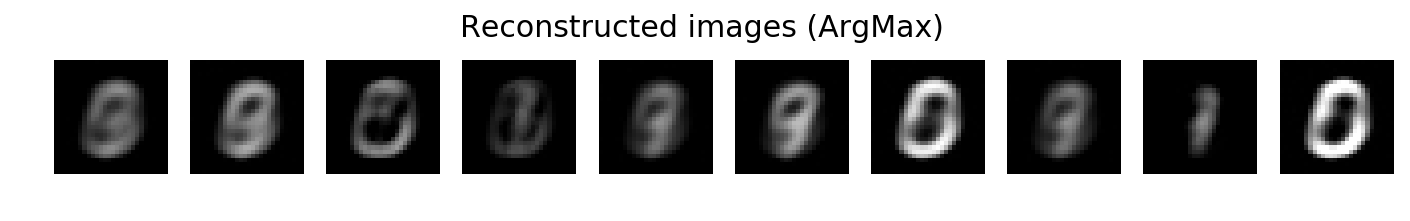

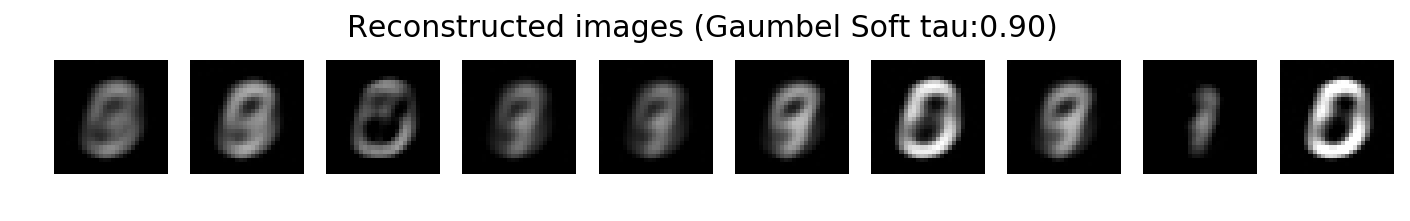

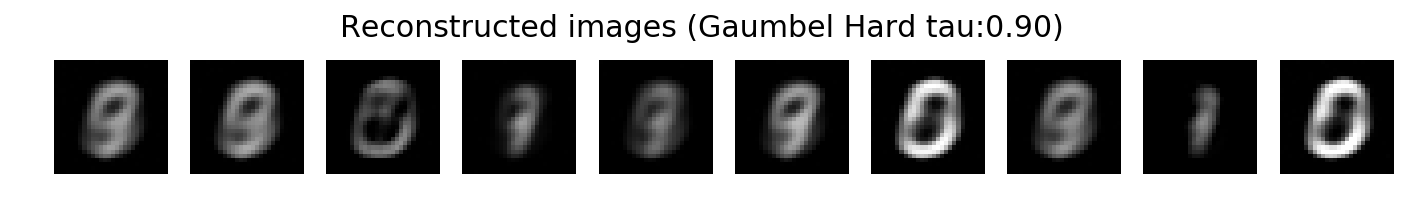

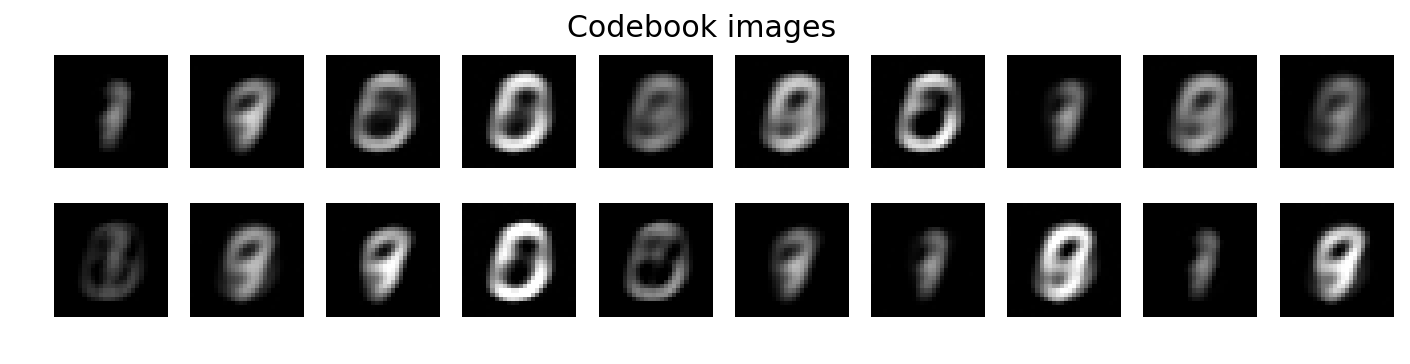

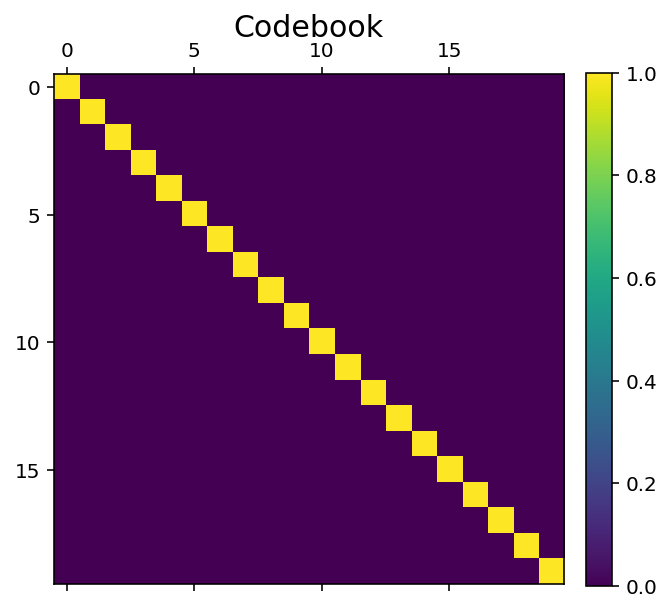

[11/100] total:[0.174] l1:[0.115] l2:[0.062] utilization:[-0.003] tau:[0.890]
[12/100] total:[0.174] l1:[0.114] l2:[0.062] utilization:[-0.003] tau:[0.880]
[13/100] total:[0.173] l1:[0.114] l2:[0.062] utilization:[-0.003] tau:[0.870]
[14/100] total:[0.173] l1:[0.114] l2:[0.062] utilization:[-0.003] tau:[0.860]
[15/100] total:[0.172] l1:[0.114] l2:[0.062] utilization:[-0.003] tau:[0.850]
[16/100] total:[0.172] l1:[0.113] l2:[0.062] utilization:[-0.003] tau:[0.840]
[17/100] total:[0.172] l1:[0.113] l2:[0.062] utilization:[-0.003] tau:[0.830]
[18/100] total:[0.172] l1:[0.113] l2:[0.062] utilization:[-0.003] tau:[0.820]
[19/100] total:[0.172] l1:[0.113] l2:[0.061] utilization:[-0.003] tau:[0.810]
[20/100] total:[0.172] l1:[0.113] l2:[0.061] utilization:[-0.003] tau:[0.800]


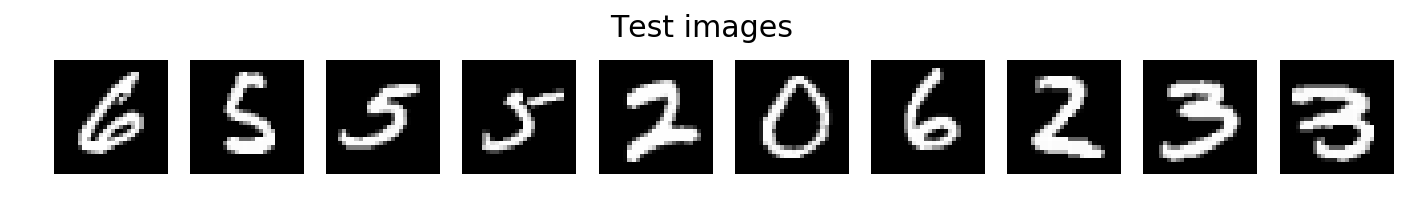

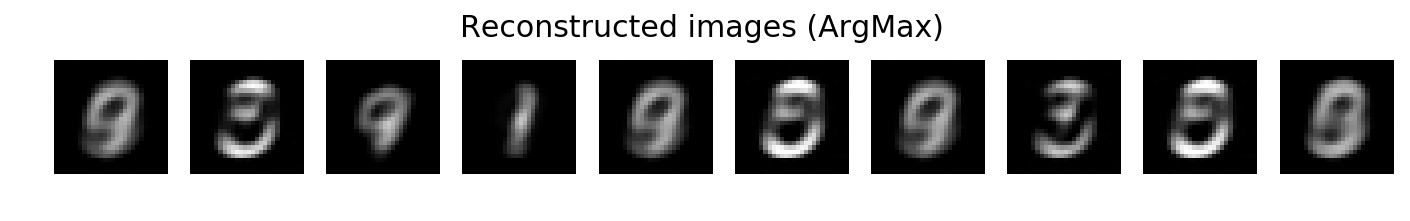

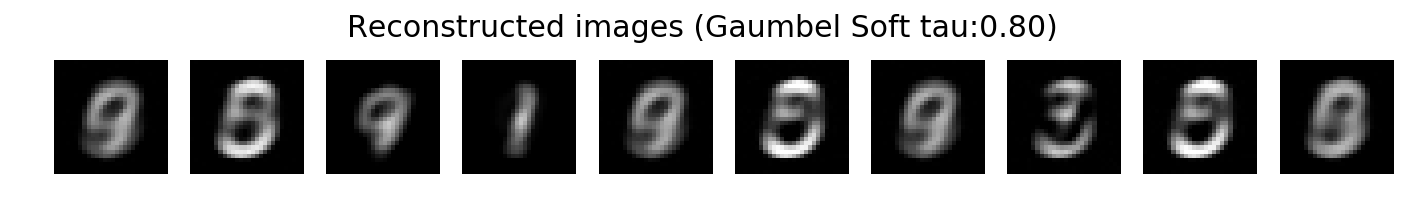

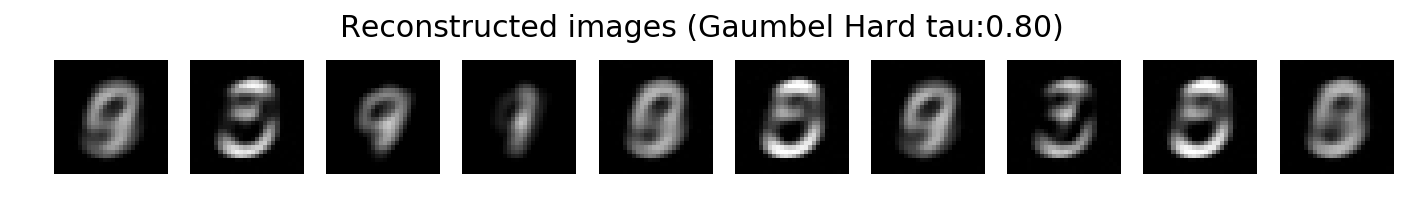

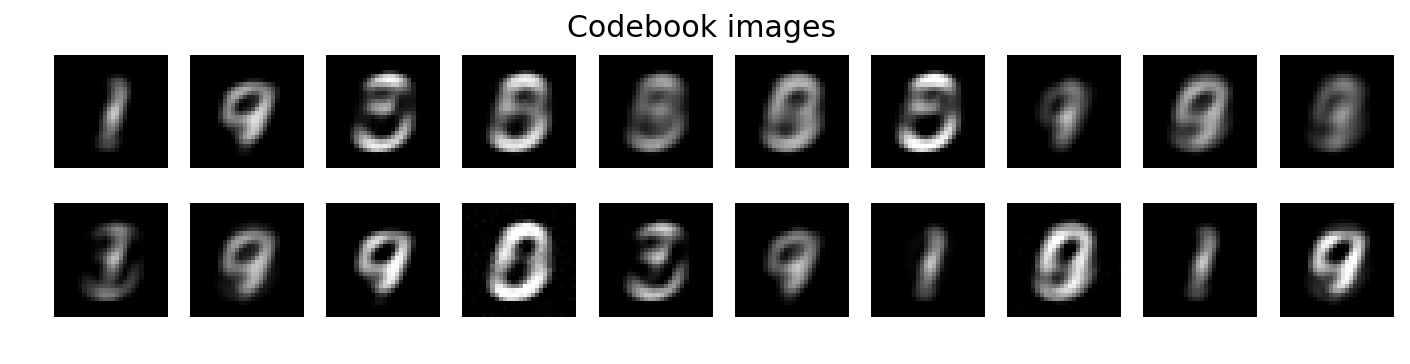

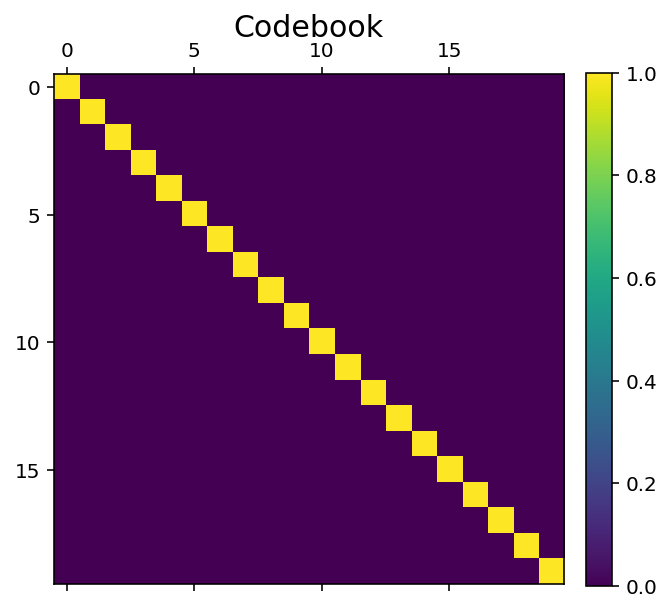

[21/100] total:[0.170] l1:[0.113] l2:[0.060] utilization:[-0.003] tau:[0.790]
[22/100] total:[0.167] l1:[0.111] l2:[0.059] utilization:[-0.003] tau:[0.780]
[23/100] total:[0.166] l1:[0.110] l2:[0.059] utilization:[-0.003] tau:[0.770]
[24/100] total:[0.165] l1:[0.110] l2:[0.058] utilization:[-0.003] tau:[0.760]
[25/100] total:[0.165] l1:[0.109] l2:[0.058] utilization:[-0.003] tau:[0.750]
[26/100] total:[0.164] l1:[0.109] l2:[0.058] utilization:[-0.003] tau:[0.740]
[27/100] total:[0.163] l1:[0.108] l2:[0.057] utilization:[-0.003] tau:[0.730]
[28/100] total:[0.161] l1:[0.108] l2:[0.056] utilization:[-0.003] tau:[0.720]
[29/100] total:[0.160] l1:[0.107] l2:[0.056] utilization:[-0.003] tau:[0.710]
[30/100] total:[0.159] l1:[0.107] l2:[0.055] utilization:[-0.003] tau:[0.700]


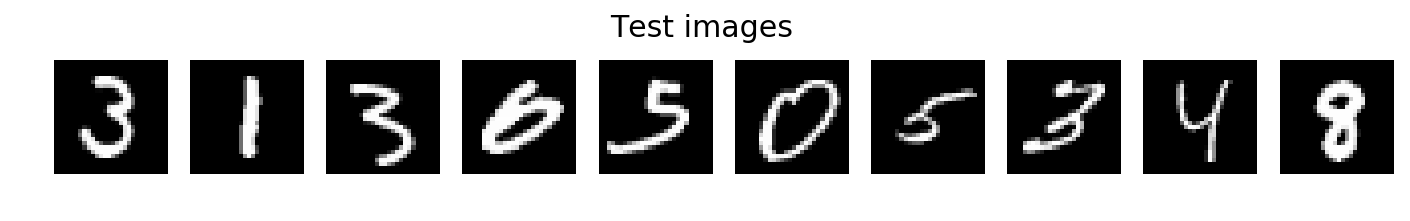

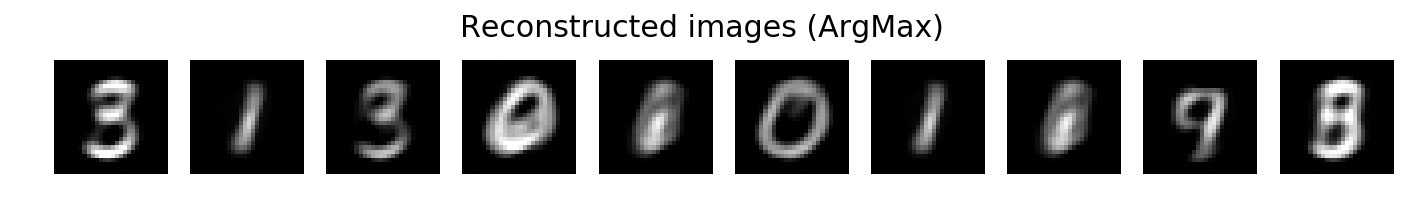

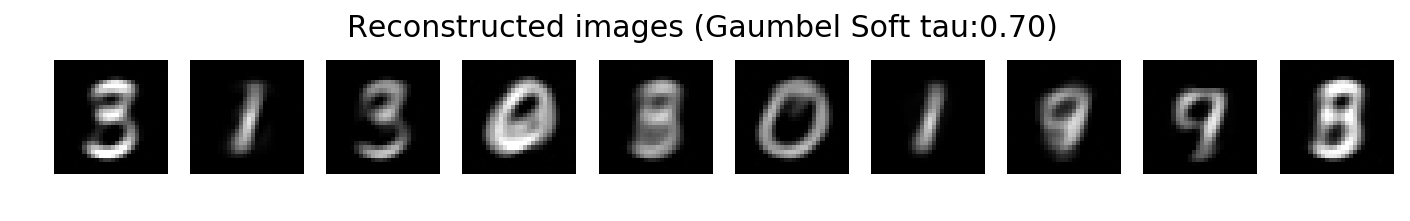

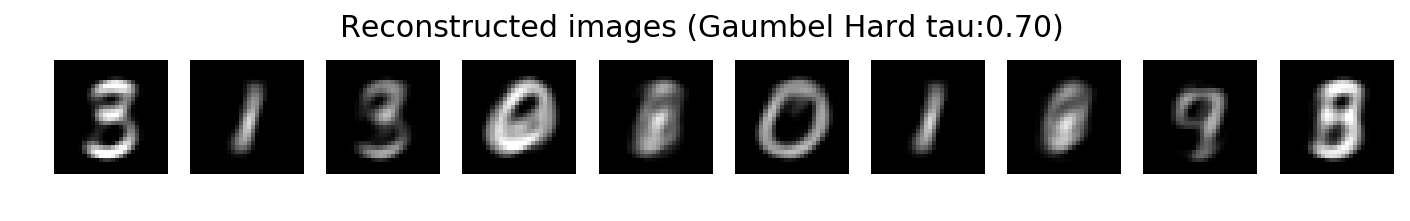

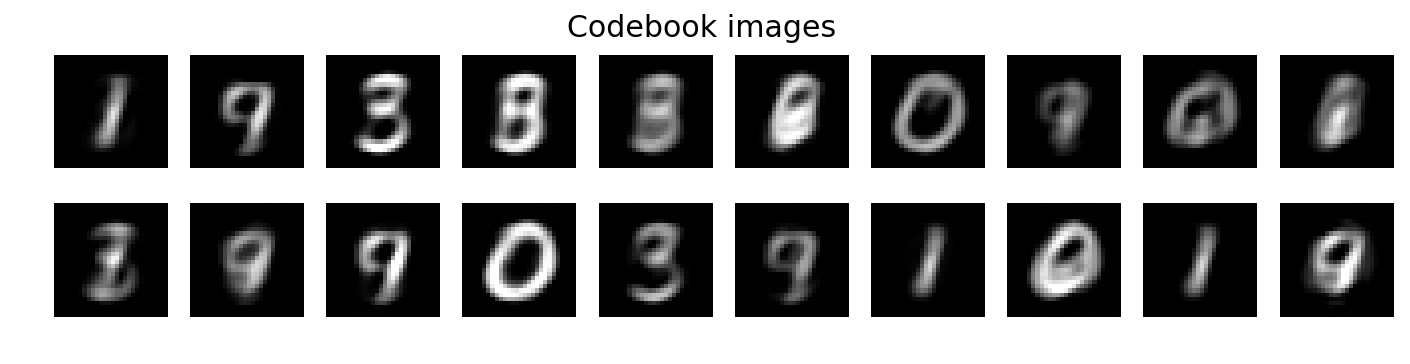

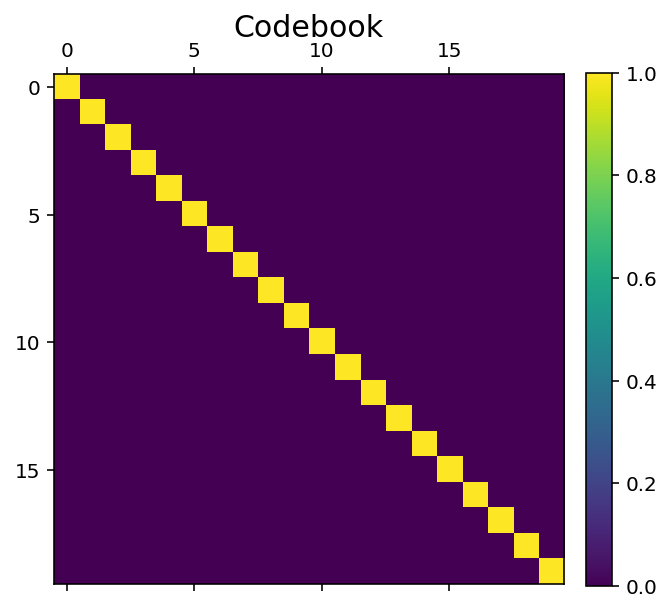

[31/100] total:[0.159] l1:[0.106] l2:[0.055] utilization:[-0.003] tau:[0.690]
[32/100] total:[0.159] l1:[0.106] l2:[0.055] utilization:[-0.003] tau:[0.680]
[33/100] total:[0.158] l1:[0.106] l2:[0.055] utilization:[-0.003] tau:[0.670]
[34/100] total:[0.158] l1:[0.106] l2:[0.055] utilization:[-0.003] tau:[0.660]
[35/100] total:[0.158] l1:[0.106] l2:[0.054] utilization:[-0.003] tau:[0.650]
[36/100] total:[0.157] l1:[0.106] l2:[0.054] utilization:[-0.003] tau:[0.640]
[37/100] total:[0.155] l1:[0.105] l2:[0.053] utilization:[-0.003] tau:[0.630]
[38/100] total:[0.154] l1:[0.104] l2:[0.053] utilization:[-0.003] tau:[0.620]
[39/100] total:[0.154] l1:[0.104] l2:[0.053] utilization:[-0.003] tau:[0.610]
[40/100] total:[0.153] l1:[0.104] l2:[0.052] utilization:[-0.003] tau:[0.600]


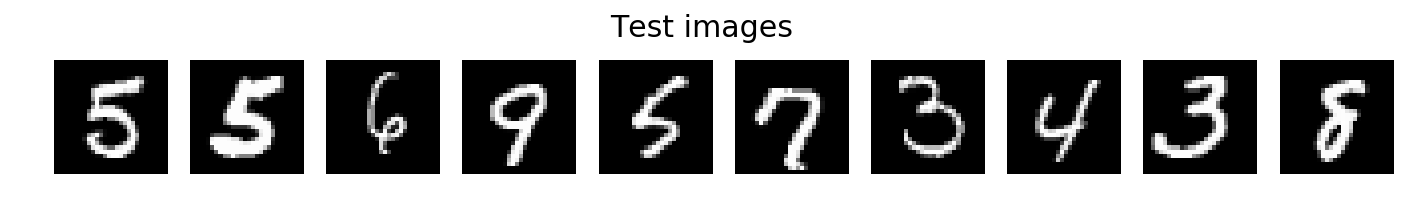

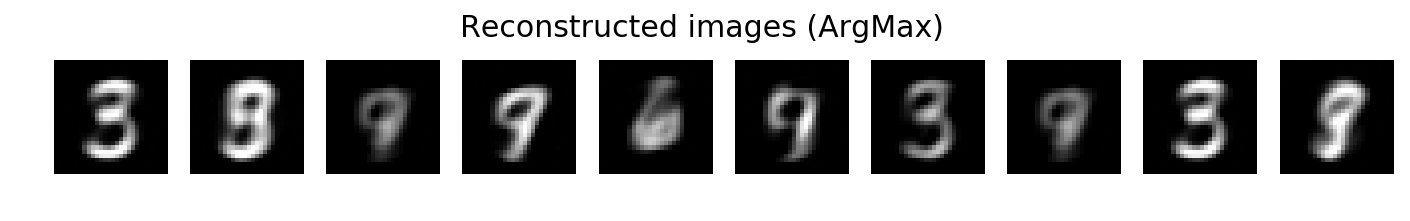

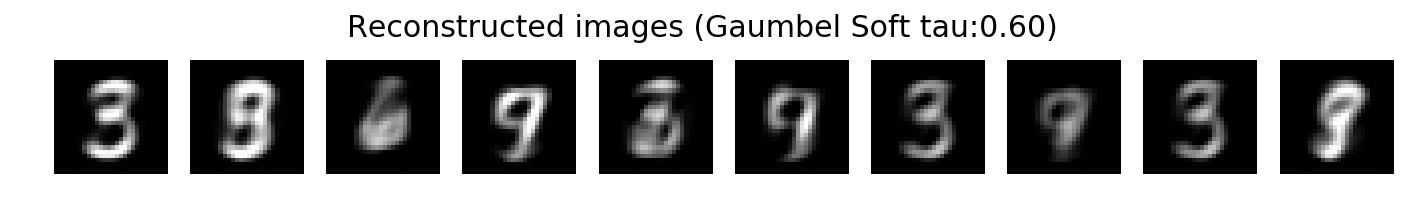

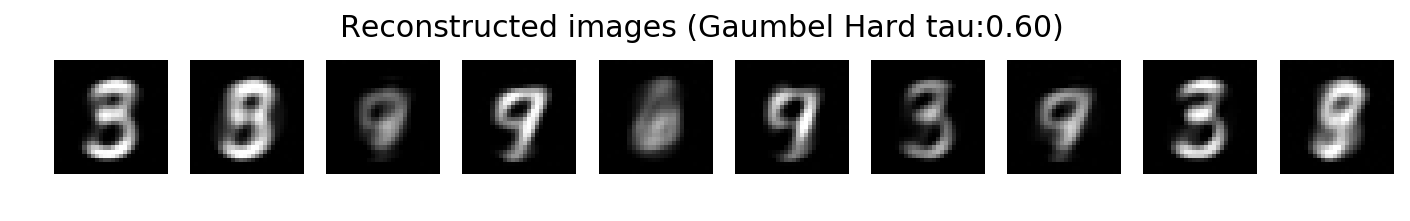

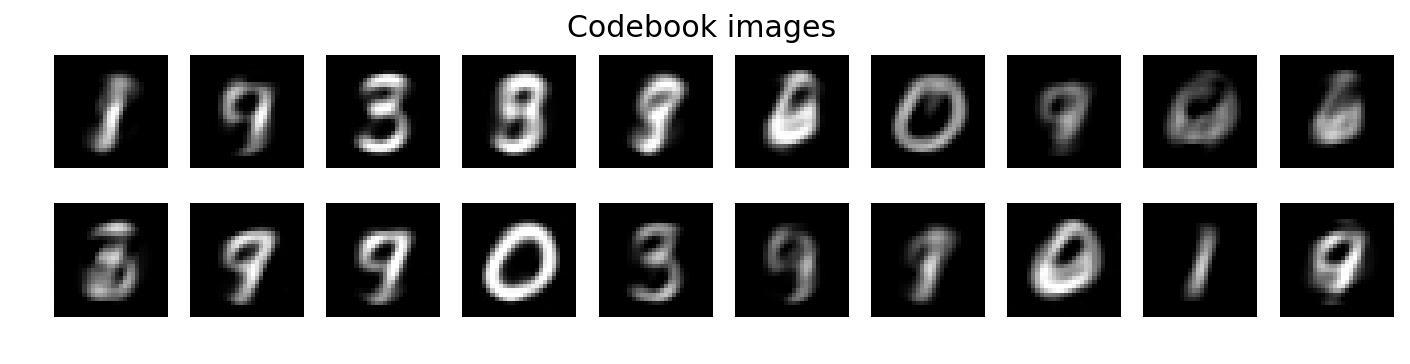

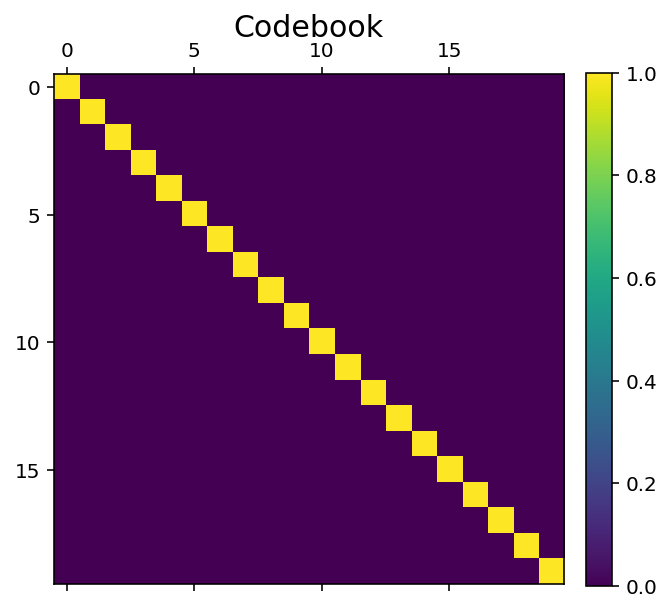

[41/100] total:[0.153] l1:[0.103] l2:[0.052] utilization:[-0.003] tau:[0.590]
[42/100] total:[0.153] l1:[0.103] l2:[0.052] utilization:[-0.003] tau:[0.580]
[43/100] total:[0.152] l1:[0.103] l2:[0.052] utilization:[-0.003] tau:[0.570]
[44/100] total:[0.152] l1:[0.103] l2:[0.052] utilization:[-0.003] tau:[0.560]
[45/100] total:[0.152] l1:[0.103] l2:[0.052] utilization:[-0.003] tau:[0.550]
[46/100] total:[0.152] l1:[0.103] l2:[0.051] utilization:[-0.003] tau:[0.540]
[47/100] total:[0.151] l1:[0.103] l2:[0.051] utilization:[-0.003] tau:[0.530]
[48/100] total:[0.150] l1:[0.102] l2:[0.051] utilization:[-0.003] tau:[0.520]
[49/100] total:[0.149] l1:[0.102] l2:[0.051] utilization:[-0.003] tau:[0.510]
[50/100] total:[0.149] l1:[0.101] l2:[0.051] utilization:[-0.003] tau:[0.500]


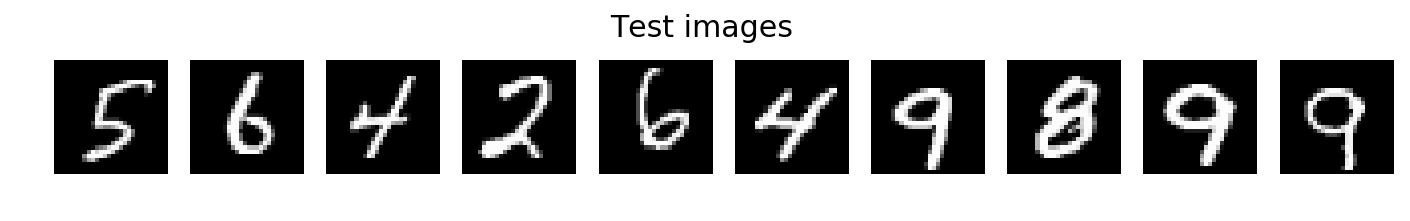

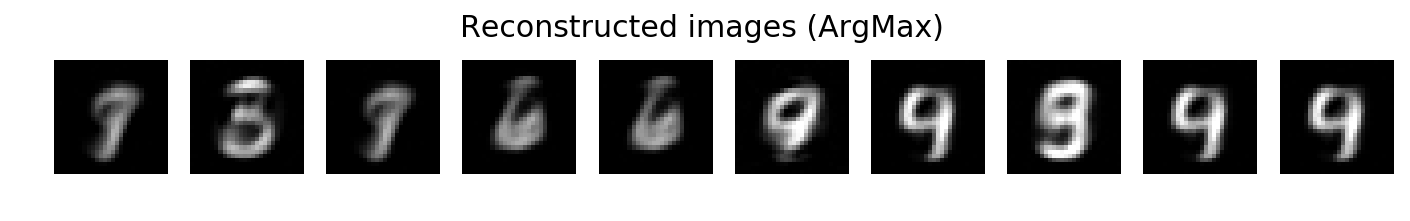

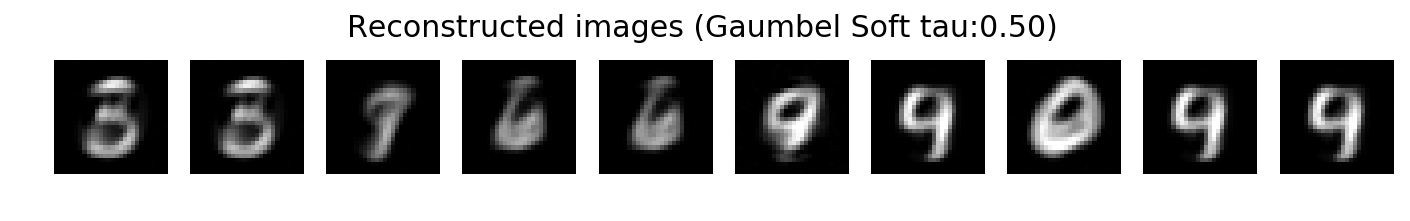

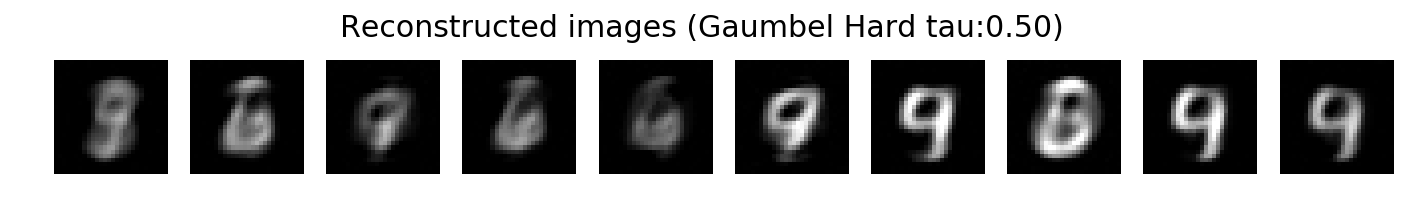

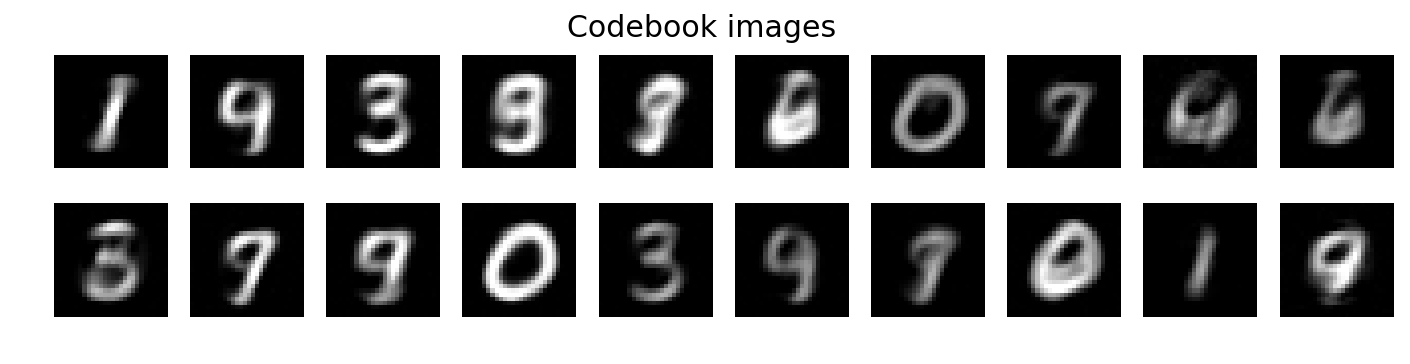

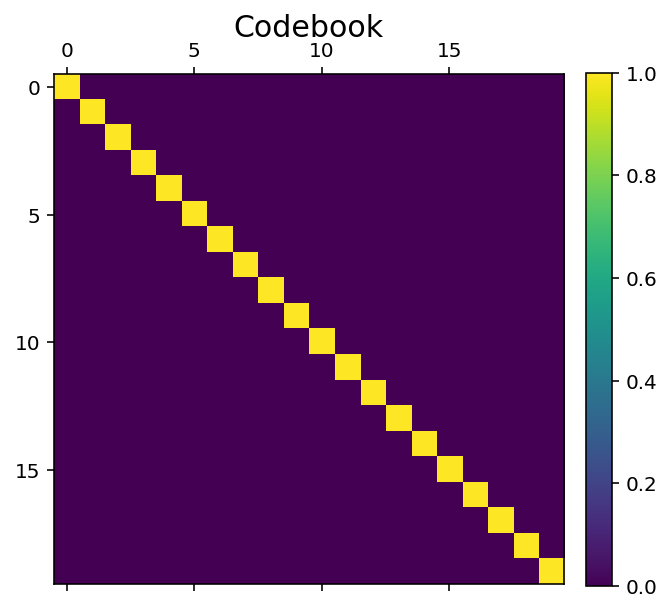

[51/100] total:[0.148] l1:[0.101] l2:[0.050] utilization:[-0.003] tau:[0.490]
[52/100] total:[0.147] l1:[0.100] l2:[0.050] utilization:[-0.003] tau:[0.480]
[53/100] total:[0.147] l1:[0.100] l2:[0.050] utilization:[-0.003] tau:[0.470]
[54/100] total:[0.146] l1:[0.100] l2:[0.049] utilization:[-0.003] tau:[0.460]
[55/100] total:[0.146] l1:[0.100] l2:[0.049] utilization:[-0.003] tau:[0.450]
[56/100] total:[0.145] l1:[0.099] l2:[0.049] utilization:[-0.003] tau:[0.440]
[57/100] total:[0.145] l1:[0.099] l2:[0.049] utilization:[-0.003] tau:[0.430]
[58/100] total:[0.144] l1:[0.099] l2:[0.048] utilization:[-0.003] tau:[0.420]
[59/100] total:[0.144] l1:[0.099] l2:[0.048] utilization:[-0.003] tau:[0.410]
[60/100] total:[0.143] l1:[0.098] l2:[0.048] utilization:[-0.003] tau:[0.400]


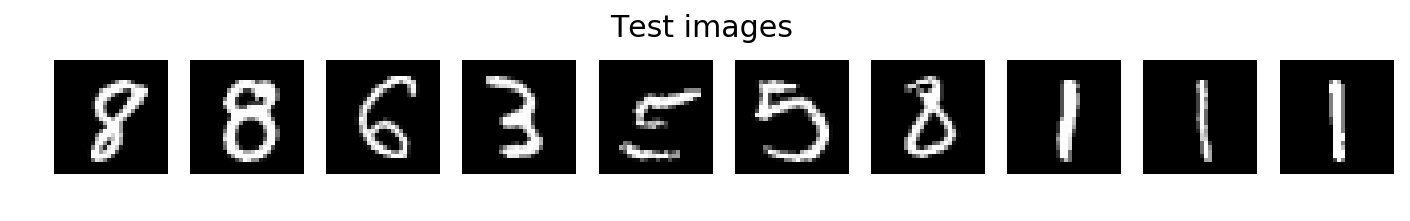

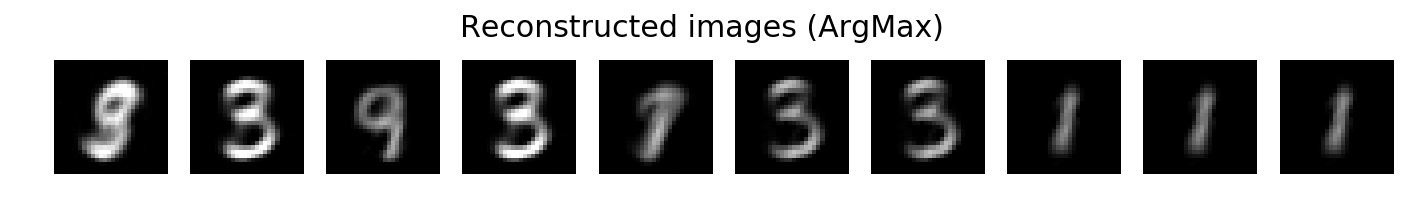

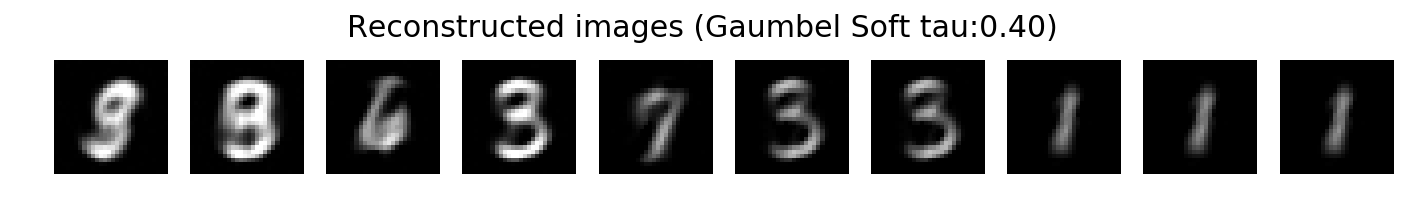

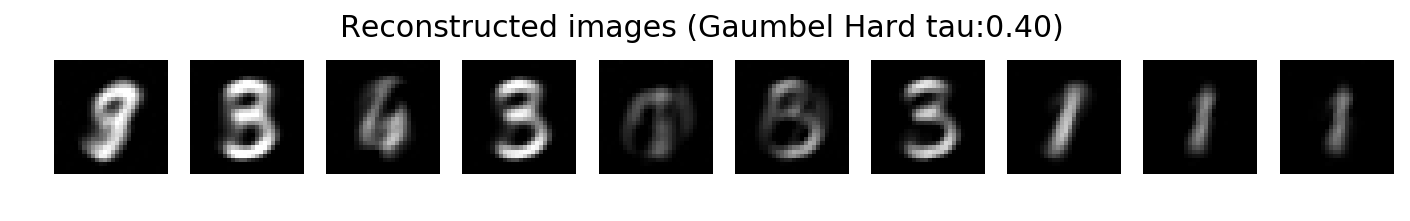

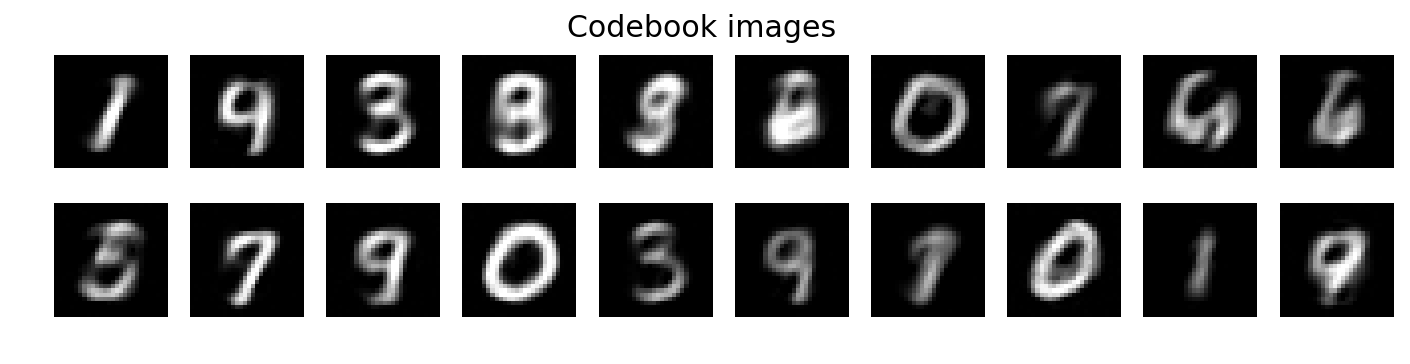

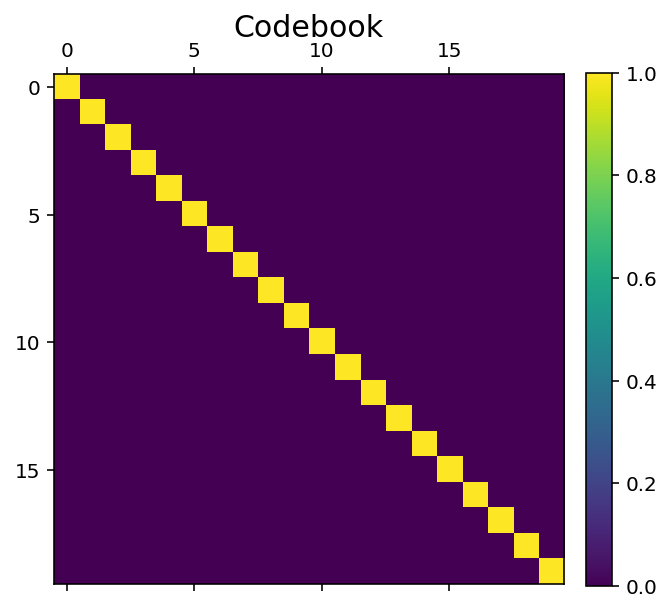

[61/100] total:[0.143] l1:[0.098] l2:[0.047] utilization:[-0.003] tau:[0.390]
[62/100] total:[0.142] l1:[0.098] l2:[0.047] utilization:[-0.003] tau:[0.380]
[63/100] total:[0.142] l1:[0.098] l2:[0.047] utilization:[-0.003] tau:[0.370]
[64/100] total:[0.141] l1:[0.097] l2:[0.047] utilization:[-0.003] tau:[0.360]
[65/100] total:[0.141] l1:[0.097] l2:[0.046] utilization:[-0.003] tau:[0.350]
[66/100] total:[0.140] l1:[0.097] l2:[0.046] utilization:[-0.003] tau:[0.340]
[67/100] total:[0.140] l1:[0.097] l2:[0.046] utilization:[-0.003] tau:[0.330]
[68/100] total:[0.139] l1:[0.096] l2:[0.046] utilization:[-0.003] tau:[0.320]
[69/100] total:[0.139] l1:[0.096] l2:[0.045] utilization:[-0.003] tau:[0.310]
[70/100] total:[0.138] l1:[0.096] l2:[0.045] utilization:[-0.003] tau:[0.300]


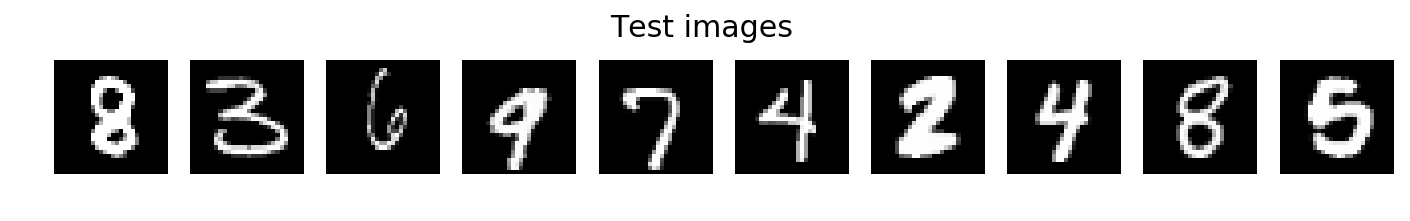

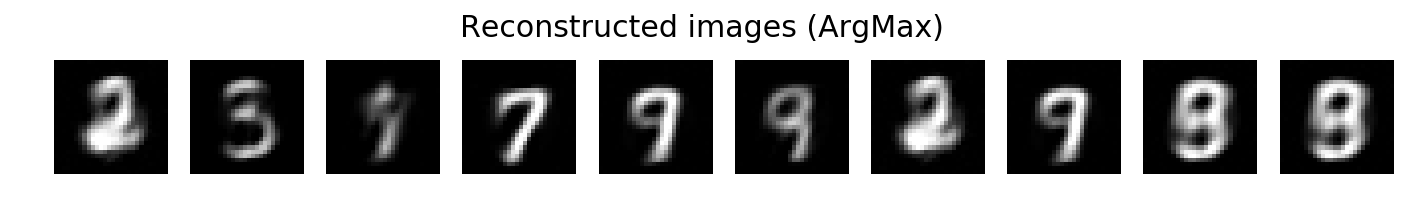

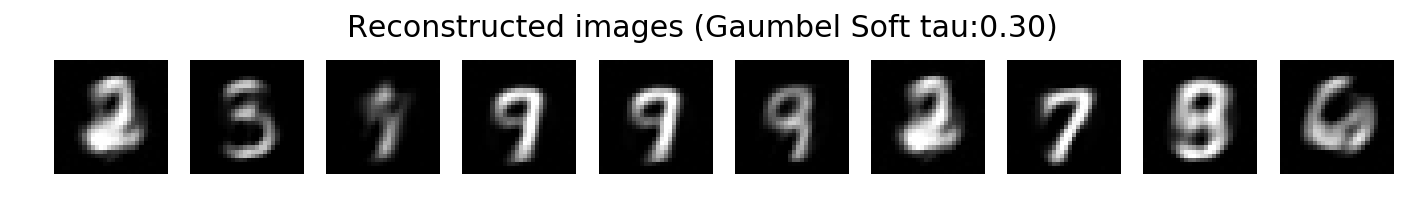

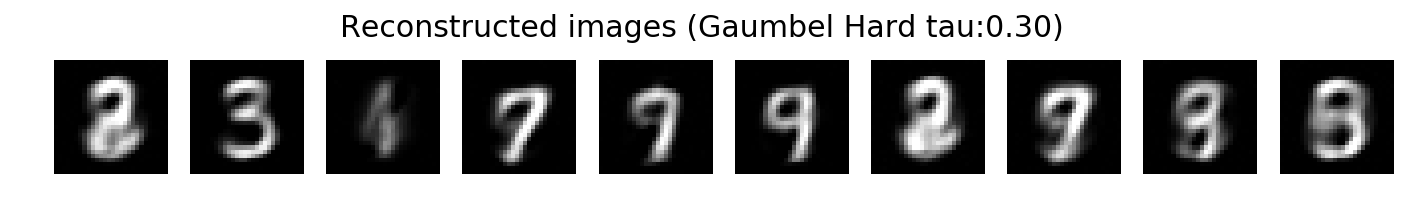

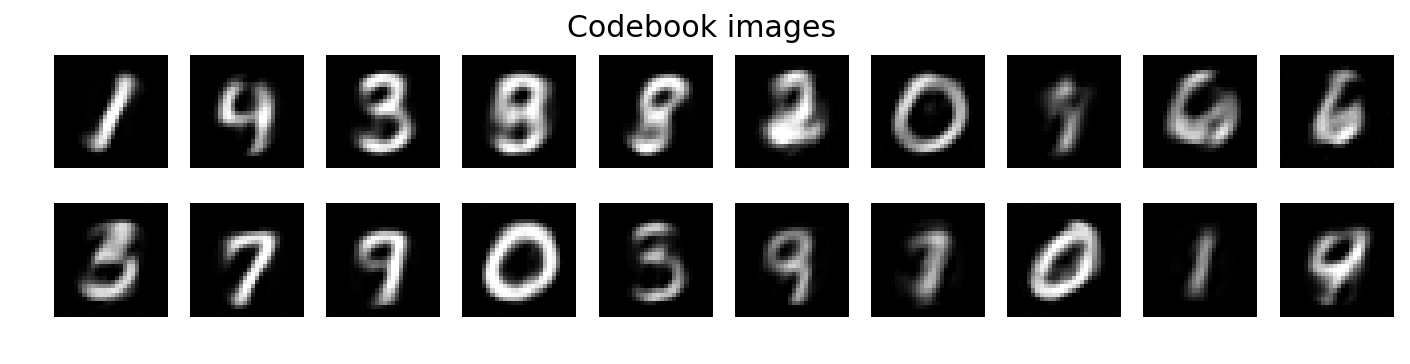

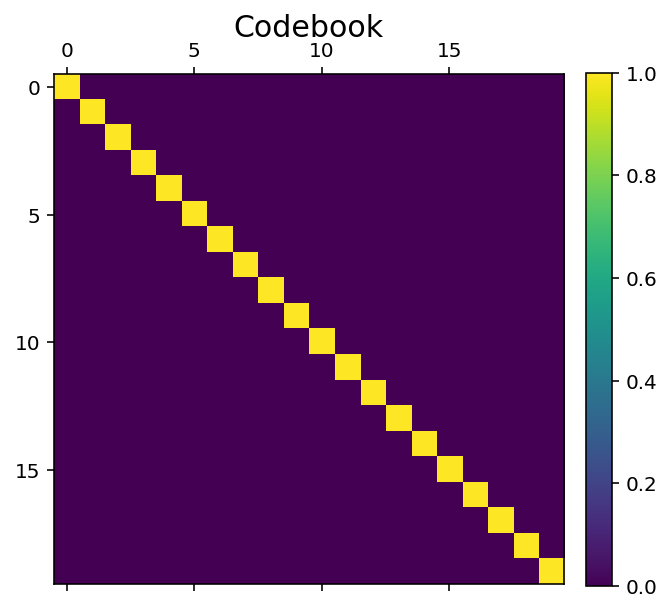

[71/100] total:[0.138] l1:[0.096] l2:[0.045] utilization:[-0.003] tau:[0.290]
[72/100] total:[0.137] l1:[0.095] l2:[0.045] utilization:[-0.003] tau:[0.280]
[73/100] total:[0.137] l1:[0.095] l2:[0.045] utilization:[-0.003] tau:[0.270]
[74/100] total:[0.136] l1:[0.095] l2:[0.044] utilization:[-0.003] tau:[0.260]
[75/100] total:[0.135] l1:[0.094] l2:[0.044] utilization:[-0.003] tau:[0.250]
[76/100] total:[0.135] l1:[0.094] l2:[0.044] utilization:[-0.003] tau:[0.240]
[77/100] total:[0.134] l1:[0.094] l2:[0.044] utilization:[-0.003] tau:[0.230]
[78/100] total:[0.134] l1:[0.093] l2:[0.043] utilization:[-0.003] tau:[0.220]
[79/100] total:[0.134] l1:[0.093] l2:[0.043] utilization:[-0.003] tau:[0.210]
[80/100] total:[0.133] l1:[0.093] l2:[0.043] utilization:[-0.003] tau:[0.200]


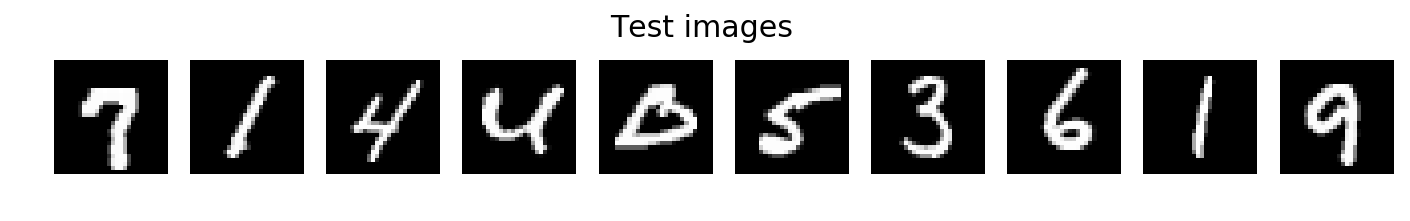

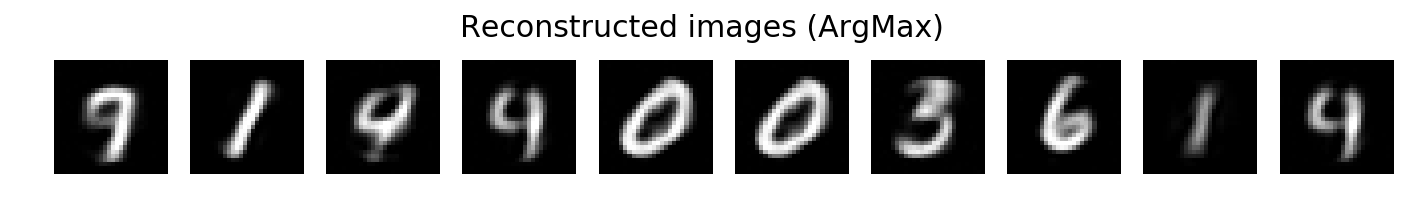

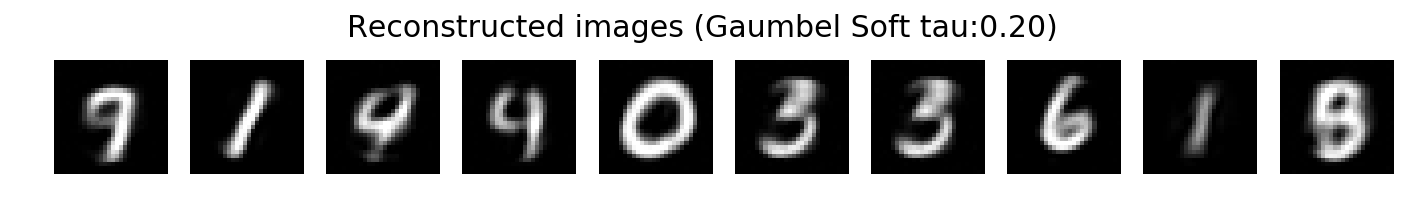

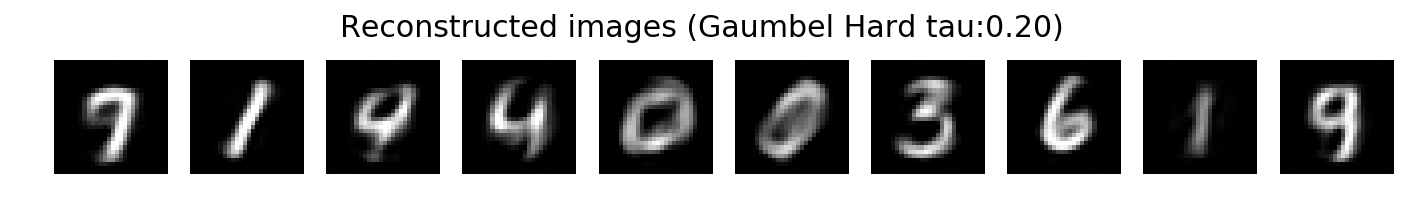

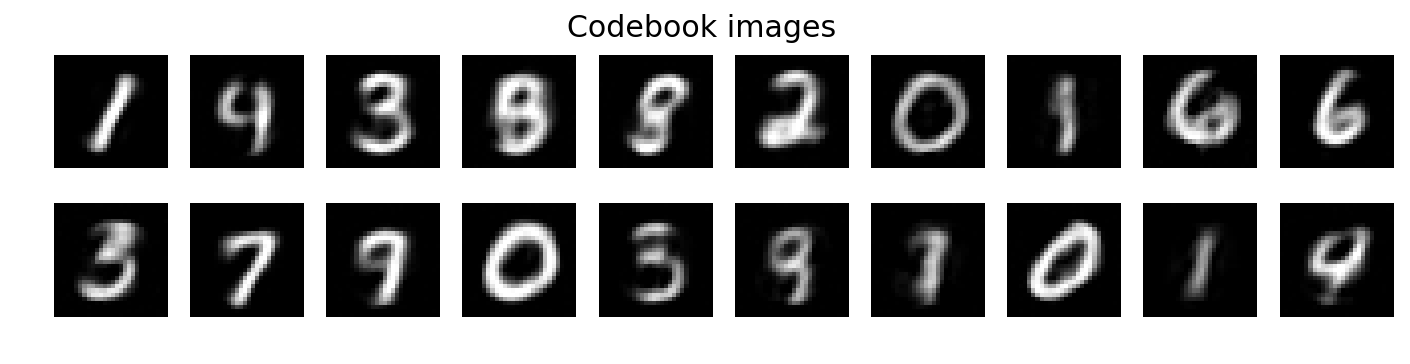

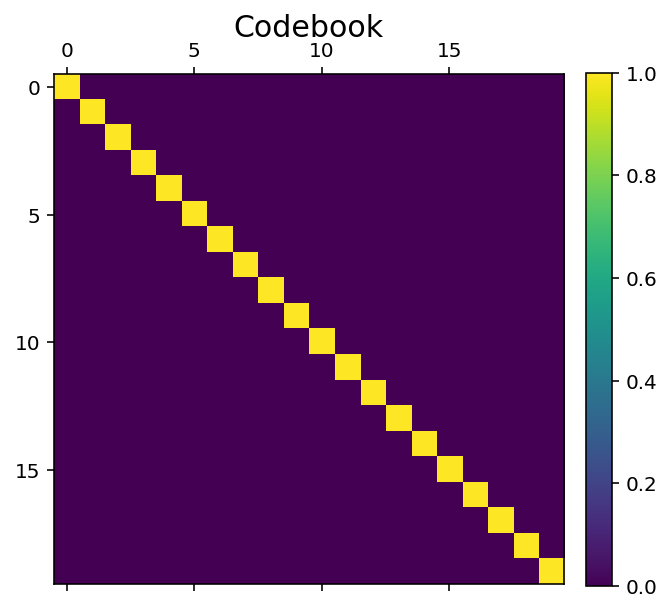

[81/100] total:[0.133] l1:[0.093] l2:[0.043] utilization:[-0.003] tau:[0.190]
[82/100] total:[0.132] l1:[0.092] l2:[0.043] utilization:[-0.003] tau:[0.180]
[83/100] total:[0.132] l1:[0.092] l2:[0.043] utilization:[-0.003] tau:[0.170]
[84/100] total:[0.131] l1:[0.092] l2:[0.042] utilization:[-0.003] tau:[0.160]
[85/100] total:[0.131] l1:[0.092] l2:[0.042] utilization:[-0.003] tau:[0.150]
[86/100] total:[0.131] l1:[0.091] l2:[0.042] utilization:[-0.003] tau:[0.140]
[87/100] total:[0.130] l1:[0.091] l2:[0.042] utilization:[-0.003] tau:[0.130]
[88/100] total:[0.130] l1:[0.091] l2:[0.042] utilization:[-0.003] tau:[0.120]
[89/100] total:[0.129] l1:[0.091] l2:[0.042] utilization:[-0.003] tau:[0.110]
[90/100] total:[0.129] l1:[0.090] l2:[0.041] utilization:[-0.003] tau:[0.100]


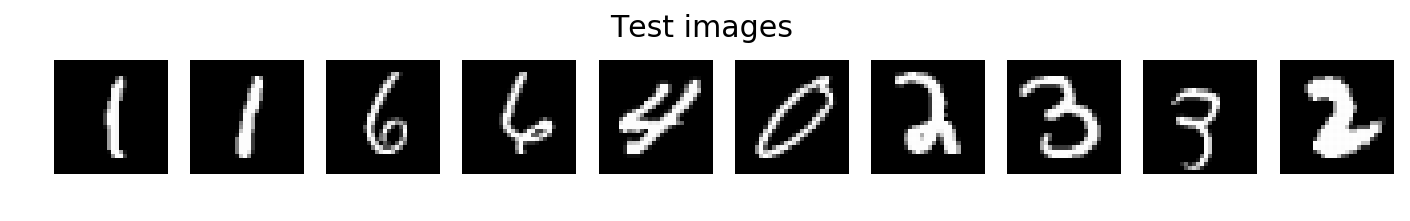

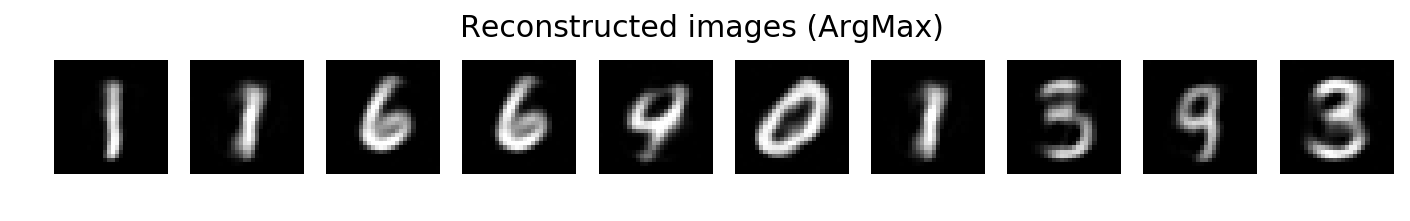

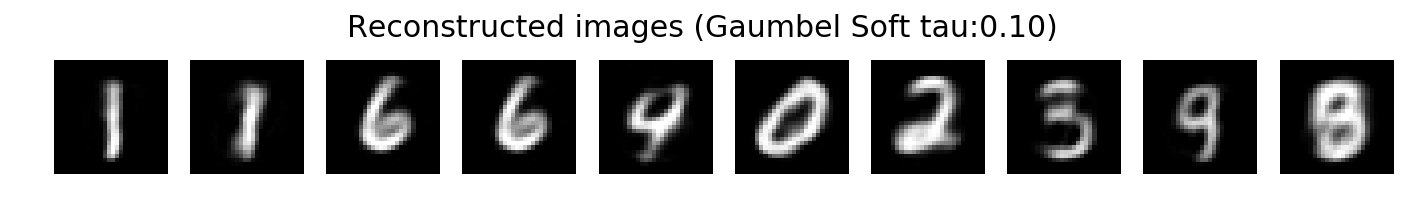

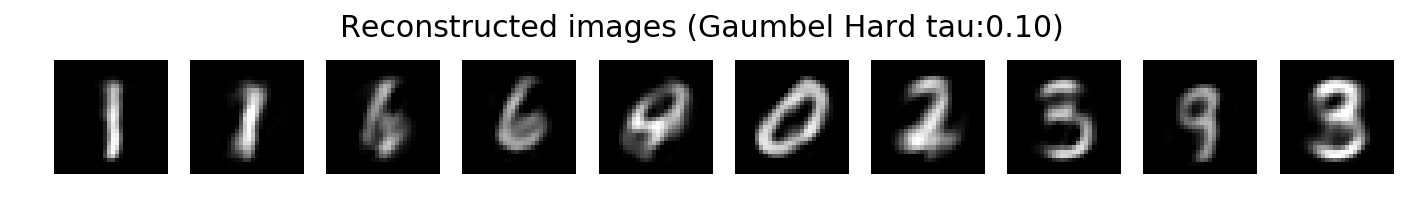

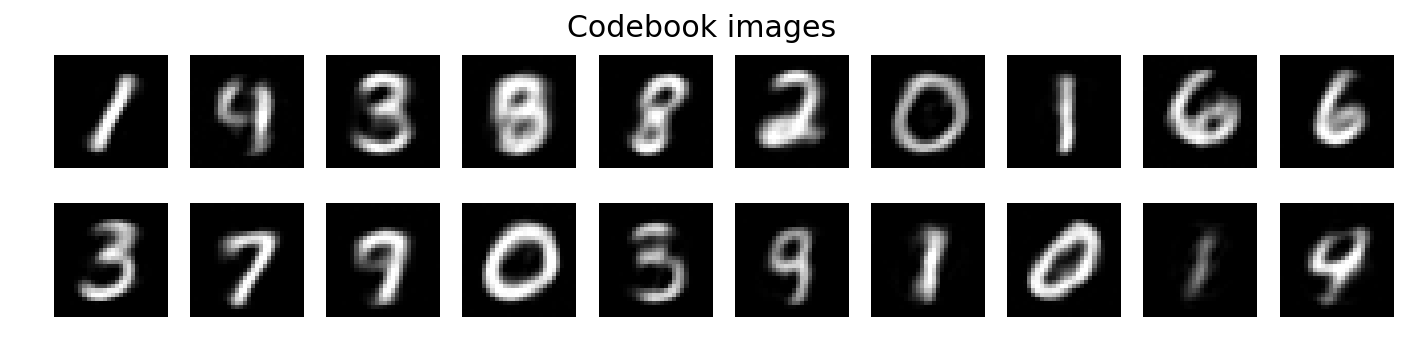

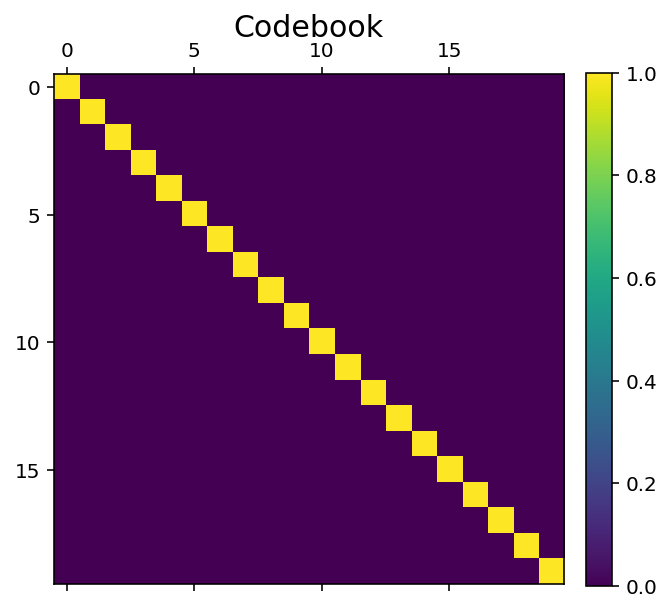

[91/100] total:[0.129] l1:[0.090] l2:[0.041] utilization:[-0.003] tau:[0.090]
[92/100] total:[0.128] l1:[0.090] l2:[0.041] utilization:[-0.003] tau:[0.080]
[93/100] total:[0.128] l1:[0.090] l2:[0.041] utilization:[-0.003] tau:[0.070]
[94/100] total:[0.128] l1:[0.090] l2:[0.041] utilization:[-0.003] tau:[0.060]
[95/100] total:[0.127] l1:[0.090] l2:[0.041] utilization:[-0.003] tau:[0.050]
[96/100] total:[0.127] l1:[0.089] l2:[0.041] utilization:[-0.003] tau:[0.040]
[97/100] total:[0.127] l1:[0.089] l2:[0.041] utilization:[-0.003] tau:[0.030]
[98/100] total:[0.127] l1:[0.089] l2:[0.040] utilization:[-0.003] tau:[0.020]
[99/100] total:[0.126] l1:[0.089] l2:[0.040] utilization:[-0.003] tau:[0.010]


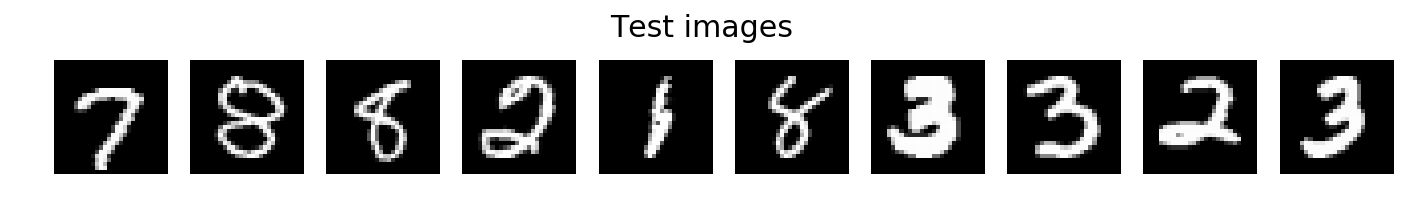

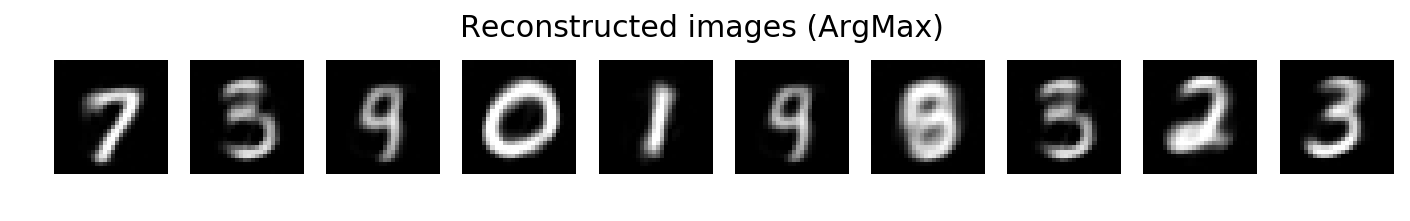

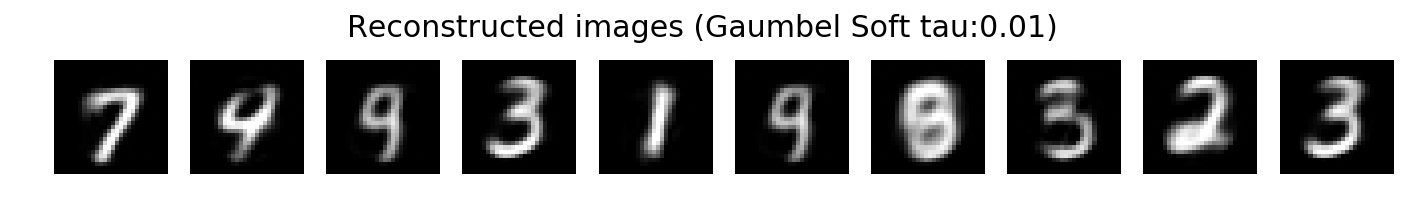

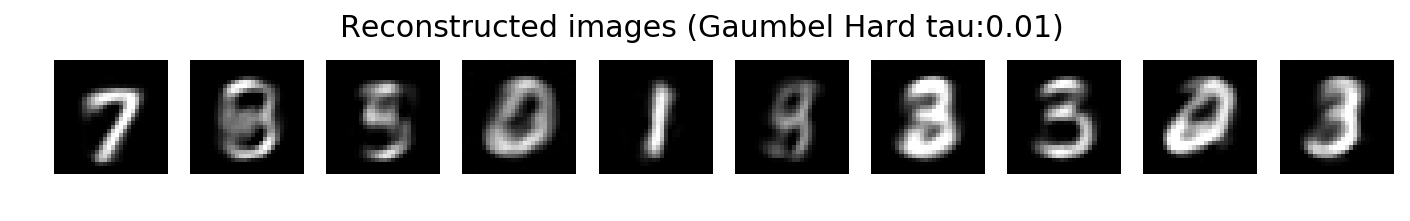

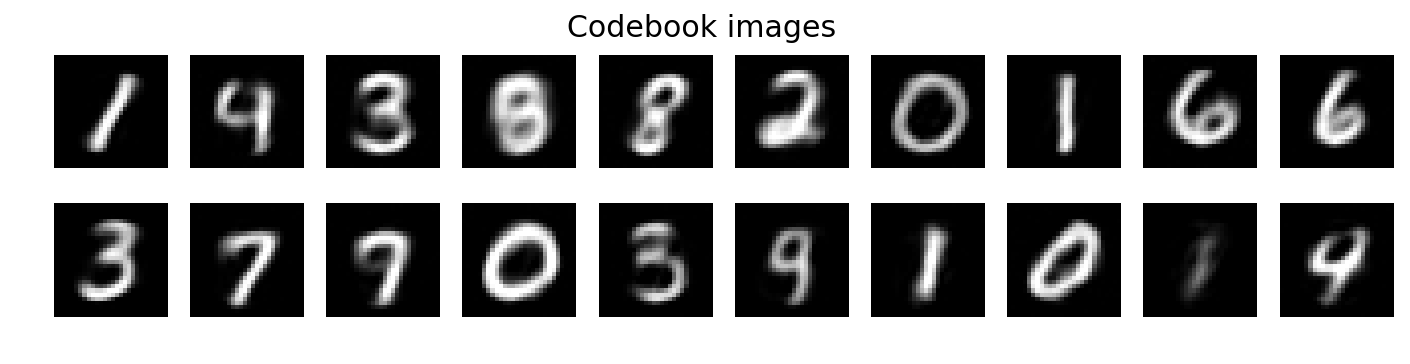

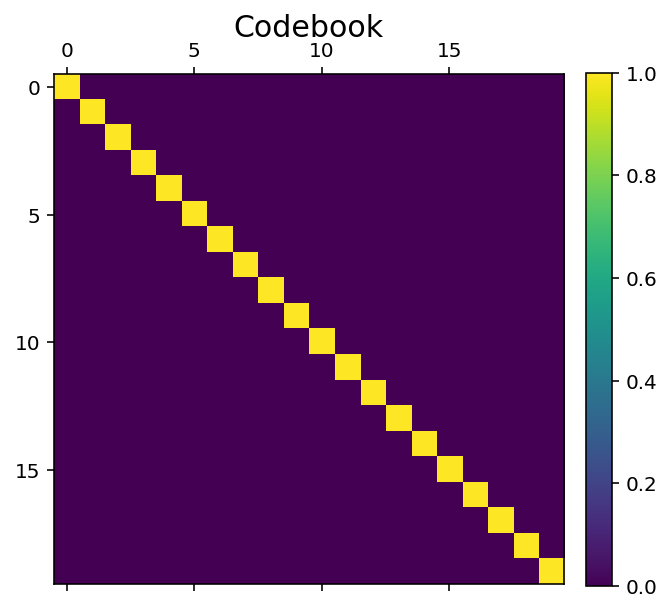

Done.


In [10]:
print ("Start training.")
GQVAE.init_params()
for epoch in range(n_epoch):
    zero_to_one = float(epoch/(n_epoch-1))
    one_to_zero = 1-zero_to_one
    loss_recon_sum,loss_embedding_sum,loss_total_sum,n_batch_sum = 0.0,0.0,0.0,0
    rand_idxs = np.random.permutation(n_train)
    total_loss_sum,util_loss_sum,l1_loss_sum,l2_loss_sum = 0.0,0.0,0.0,0.0
    for it in range(n_it):
        batch_idx     = rand_idxs[it*batch_size:(it+1)*batch_size]
        # Concatenate batch with high reconstruction errors
        NEGATIVE_RESAMPLE = False
        if (epoch >= 1) and NEGATIVE_RESAMPLE:
            choice_idx = np.random.choice(len(recon_idxs),batch_size,replace=False)
            batch_idx  = np.concatenate((batch_idx,recon_idxs[choice_idx]))
        x_batch_torch = x_train_torch[batch_idx,:].to(GQVAE.device)
        n_batch       = x_batch_torch.shape[0]
        # Temperature scheduling
        tau_curr = (tau_max-tau_min)*one_to_zero + tau_min
        # Update
        ONEHOT = True if (np.random.rand()<0.5) else False # randomize onehot
        loss_out = GQVAE.loss(
            x            = x_batch_torch,
            tau          = tau_curr,
            USE_GUMBEL   = True,
            ONEHOT       = ONEHOT,
            ARGMAX       = False,
            l1_weight    = 1.0,
            l2_weight    = 1.0,
            util_weight  = 0.001
        )
        optm.zero_grad(); loss_out['total_loss'].backward(); optm.step()
        total_loss_sum = total_loss_sum + loss_out['total_loss']
        l1_loss_sum    = l1_loss_sum + loss_out['l1_loss']
        l2_loss_sum    = l2_loss_sum + loss_out['l2_loss']
        util_loss_sum  = util_loss_sum + loss_out['util_loss']
    total_loss_avg = total_loss_sum / n_it
    util_loss_avg  = util_loss_sum / n_it
    l1_loss_avg    = l1_loss_sum / n_it
    l2_loss_avg    = l2_loss_sum / n_it
    # Compute reconstruction errors of the training data
    l2_errs    = torch2np(GQVAE.loss(x=x_train_torch,ARGMAX=True)['l2_errs']) # [N]
    recon_idxs = np.argsort(-l2_errs)[:(n_train//10)] # descending order of 10%
    # Print
    print ("[%d/%d] total:[%.3f] l1:[%.3f] l2:[%.3f] utilization:[%.3f] tau:[%.3f]"%
           (epoch,n_epoch,total_loss_avg,l1_loss_avg,l2_loss_avg,util_loss_avg,tau_curr))
    # Plot
    if ((epoch%plot_every) == 0) or (epoch==(n_epoch-1)):
        gqvae_mnist_debug(GQVAE_TEST=GQVAE,tau=tau_curr)
print ("Done.")